# Fall 2025

### Pressurized Ocean

In [ ]:
# preamble

import os
import sys
import matplotlib.pyplot as plt
import pdb
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
from matplotlib import ticker
import scipy as sp
from scipy.integrate import cumulative_trapezoid, trapezoid, odeint, solve_bvp, solve_ivp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import matplotlib.ticker as mtick
from matplotlib.ticker import LogLocator, FuncFormatter, NullFormatter, FixedLocator, StrMethodFormatter, LogFormatter, LogFormatterSciNotation, LogFormatterExponent, LogFormatterMathtext, FixedFormatter
from matplotlib.lines import lineStyles
import cmocean
import cmocean.cm as cmo
from matplotlib.colors import LogNorm
from IPython.display import clear_output
import matplotlib.patheffects as pe
from matplotlib.collections import LineCollection
def sci_fmt(x):
    if x == 0 or not np.isfinite(x):
        return "0"
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / (10**exp)
    # round mantissa to integer as you requested
    return rf"{mant:.0f}$×10^{{exp}}$"



In [266]:
# constants
beta = 4e-10 # Pa-1, compressibility at ~273.15 K
rhow = 1025 # kg m-3
rhoi = 916 # kg m-3
delta_rho = rhow - rhoi # kg m-3
Cp = 4.2e3 # J kg-1 K
kappa = 1e-6 # thermal diffusivity (m2/s)
λ = 0.65 # thermodynamic parameter of ice (adimensional)
g = 1.315 # m/s2
nu = 0.3 # Poisson's ratio
E = 5e9 # Pa, Young's modulus
G = 3.3e9 # Pa, shear modulus from Berne et al., 2023
m = G / (1 - nu)
eta_w = 1e-3 # Pa s, viscosity of water

# tensile strength
S = 1e6 # Pa, tensile strength of ice
Kc = 1e6 # Pa m1/2, fracture toughness of ice

# depth params
ymi = 1 # m, initial ice shell thickness
R = 1.5608e6 # m, radius of Europa
rc = 1.4608e6 # m, radius to top of silicate component
rii = R - ymi # m, initial radius of ice shell base
ri_timed = np.zeros((1,2)) # m, radii of ice shell base
ri_timed[0,0] = 0
ri_timed[0] = [rii, 0]
dzi = (ymi)/61
dti = 0.1*((0.1*(dzi**2))/kappa)

## time params
y2sec = 3.1536e7 # s/yr
tend = 5e6*y2sec # end time (s)
t = ((ymi/(2*λ))**2)/kappa # starting time (s)
n = 0 # first iteration


In [4]:
# ri, the inner radius of the ice shell with respect to time
# i.e., the radius outwards until the bottom of the elastic layer of the shell

ri_timed = np.zeros((1,2)) # m, radii of ice shell base
ri_timed[0,0] = 0
ri_timed[0] = [rii, 0]
thickness = ymi
 

t = ((R-rii)**2)/kappa # starting time (s)
n = 0 # first iteration

while t < tend:
    ξ = λ*(2*np.sqrt(kappa*t)) # calculates shell depth (m)

    if n > 1 and n % 1 == 0:
        clear_output(wait=False)
        print(f"it: {n}, thickness: {ξ/1e3:.2f} km, t: {t/y2sec/1e6:.2} Ma")

    ri_new = R - ξ # inner radii of shell
    new_ri_t = np.array([[ri_new, t/y2sec]])
    ri_timed = np.vstack((ri_timed, new_ri_t))

    dt = 100 * y2sec # linear timestep (s) *** check what timestep Manga and Wang used (page 2) ***

    t += dt
    n += 1


ri = ri_timed[:,0] # m, inner radii of ice shell
thickness = R - ri


it: 49999, thickness: 16.32 km, t: 5.0 Ma


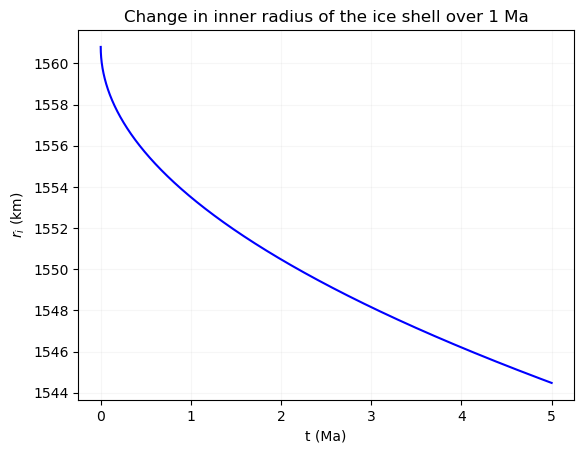

In [5]:
fig, ax = plt.subplots()

ax.plot(ri_timed[:,1]/1e6, ri_timed[:,0]/1e3, color = 'blue')
ax.set_xlabel('t (Ma)')
ax.set_ylabel('$r_i$ (km)')
ax.set_title('Change in inner radius of the ice shell over 1 Ma')
ax.grid(alpha=0.1)

In [6]:
# Overpressure

def pressure_grad(rhow, rhoi, beta, ri, rc):
    """
    Pressure gradient -- Manga & Wang (2007)

    Params:
        rhow : water density (kg/m3)
        rhoi : ice density (kg/m3)
        beta  : compressibility of water (Pa-1)
        ri    : inner radius
        rc    : silicate component radius
    Returns:
        dPex_dz 
    """
    dPex_dz = (3*(rhow-rhoi)*ri**2)/(beta*rhow*(ri**3-rc**3)) 
    return dPex_dz

In [7]:
# calculating dPex_dz over time
dPex_dzs = []
for i in range(len(ri)):
    dPex_dz = pressure_grad(rhow, rhoi, beta, ri[i], rc) # Pa/m
    dPex_dzs.append(dPex_dz)

dPex_dzs

[2836.4083111579625,
 2836.4162993561845,
 2838.3272674981927,
 2839.1337678735813,
 2839.752977318305,
 2840.2752281358194,
 2840.7355143986256,
 2841.1517842771595,
 2841.534700184841,
 2841.891209436472,
 2842.226137733763,
 2842.542998684462,
 2842.8444448040796,
 2843.1325368490434,
 2843.4089136408843,
 2843.6749039365463,
 2843.931602826911,
 2844.1799255123383,
 2844.420646141062,
 2844.654426488754,
 2844.8818375496558,
 2845.103376069805,
 2845.3194773992846,
 2845.5305256181496,
 2845.7368616112894,
 2845.938789578184,
 2846.1365823331544,
 2846.330485659842,
 2846.5207219184563,
 2846.7074930566896,
 2846.890983140585,
 2847.0713604957136,
 2847.2487795295433,
 2847.4233822912342,
 2847.595299813594,
 2847.7646532732983,
 2847.9315549986172,
 2848.0961093483816,
 2848.258413481772,
 2848.4185580351227,
 2848.576627718969,
 2848.732701846697,
 2848.8868548040314,
 2849.0391564672614,
 2849.1896725769334,
 2849.338465072649,
 2849.4855923937744,
 2849.631109750279,
 2849.7750

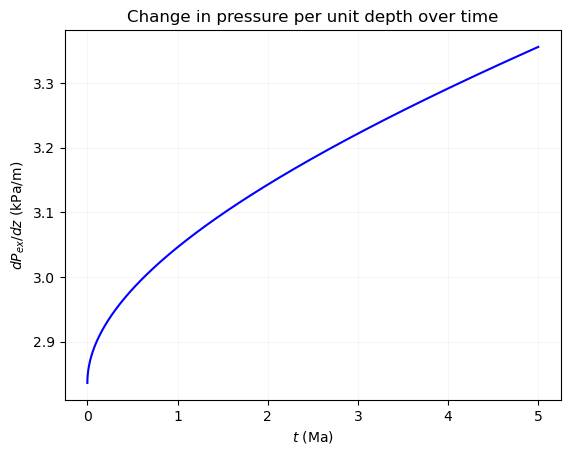

In [8]:
fig, ax = plt.subplots()
ax.plot(ri_timed[:,1]/1e6, np.array(dPex_dzs)/1e3, color = 'blue')
ax.set_xlabel('$t$ (Ma)')
ax.set_ylabel('$dP_{ex}/dz$ (kPa/m)')
ax.set_title('Change in pressure per unit depth over time')
ax.grid(alpha=0.1)

In [9]:
# hydrostatic pressure

def Ph(rhoi, g, ξ):
    """
    Calculates hydrostatic pressure at the base of the ice shell

    Params:
        rhoi : ice density (kg/m3)
        g    : gravitational acceleration (m/s2)
        ξ    : ice shell thickness (m)
    
    Returns:
        Ph   : hydrostatic pressure (Pa)

    """

    Ph = rhoi * g * ξ
    return Ph

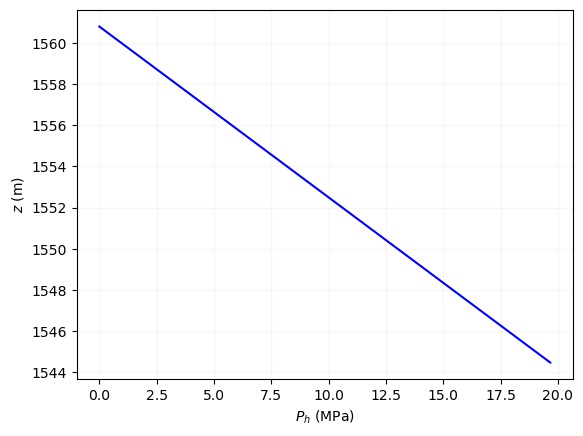

In [10]:
# hydrostatic pressure computation

Phs = []
Ph_i = np.zeros(len(ri))
Phs.append(Ph_i)
for i in range(len(ri)):
    ξ = R - ri[i]
    Ph_i = Ph(rhoi, g, ξ)
    Phs.append(Ph_i)

plt.plot(np.array(Phs[1:])/1e6, ri_timed[:,0]/1e3, color = 'blue')
plt.ylabel('$z$ (m)')
plt.xlabel('$P_h$ (MPa)')
plt.grid(alpha=0.1)

In [11]:
# dPex_dz --> Pex

def Pex(beta, rc, ur, rhow, rhoi, dz, ri):
    """
    Calculates overpressure at the base of the ice shell

    Params:
        beta : compressibility of water (Pa-1)
        rc   : radius to top of silicate component (m)
        ri   : inner radius of ice shell (m)
        ur   : radial displacement (m)
        rhow : water density (kg/m3)
        rhoi : ice density (kg/m3)
        dz    : amount of freezing (m)

    Returns:
        Pex : overpressure (Pa)
    """
    Pex = (3*ri**2)/(beta*(ri**3 - rc**3)) * ((dz*(rhow-rhoi)/(rhow))-ur)
    return Pex

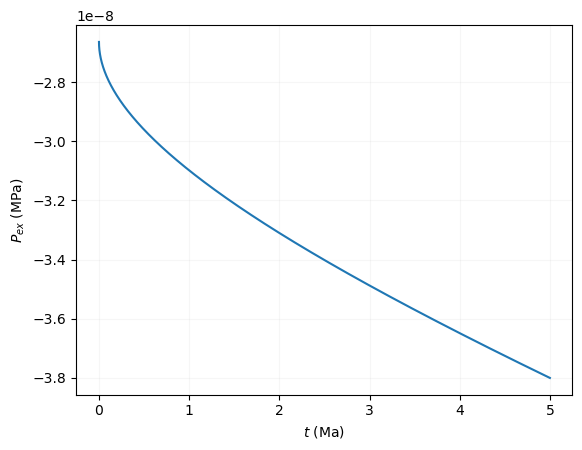

In [12]:
P = np.gradient(dPex_dzs, ri)
plt.plot(ri_timed[:,1]/1e6, P/1e6)
plt.xlabel('$t$ (Ma)')
plt.ylabel('$P_{ex}$ (MPa)')
plt.grid(alpha=0.1)

In [13]:
# calculating dPex -- change from the initial ambient pressure

dP = []
dP.append(0)

t = ((R-rii)**2)/kappa # starting time (s)
n = 0

while t < tend:
    i = min(n, len(dPex_dzs)-1)
    if i == 0:
        dz = 0
        dPex = 0
    elif i > 0:
        dz = (R - ri[i]) - (R - ri[i-1]) 
        dPex += dPex_dzs[i] * dz
    dP.append(dPex)
    
    dt = 100 * y2sec # linear timestep (s) *** check what timestep Manga and Wang used (page 2) ***

    if n % 100 == 0:
        clear_output(wait=True)
        print(f"iteration {n:.2e} complete and t = {t/y2sec/1e6:.2} Ma")
    
    t += dt
    n += 1



iteration 4.99e+04 complete and t = 5.0 Ma


Text(0.5, 1.0, '$P_{ex}$ at the ice shell base over 1 Ma')

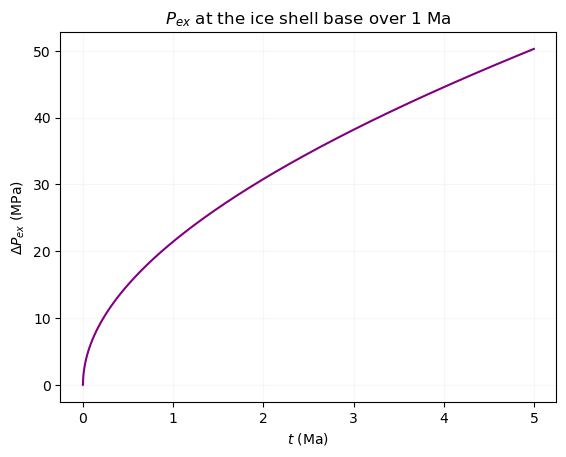

In [14]:
plt.plot(ri_timed[:,1]/1e6, np.array(dP)/1e6, color = 'purple')
plt.xlabel('$t$ (Ma)')
plt.ylabel('$\Delta P_{ex}$ (MPa)')
plt.grid(alpha=0.1)
plt.title("$P_{ex}$ at the ice shell base over 1 Ma")


In [15]:
# Excess pressure and tensile strength of the shell

Pcrit = S + np.array(Phs[1:]) # Pa, critical pressure to fracture the ice shell
dP_Pcrit = []
dP_Pcrit.append(0)

t = ((R-rii)**2)/kappa # starting time (s)
n = 0

for i in range(len(ri)):
    if i == 0:
        dz = 0
        dPex = Phs[1]
    elif i > 0:
        dz = (R - ri[i]) - (R - ri[i-1])
        if dPex <= S + Phs[i]: # if the pressure is less than the tensile strength + hydrostatic pressure
            dPex += dPex_dzs[i] * dz
        else:
            dPex = 0
    dP_Pcrit.append(dPex)

Text(0.5, 1.0, '$P_{ex}$ at the ice shell base over 1 Ma')

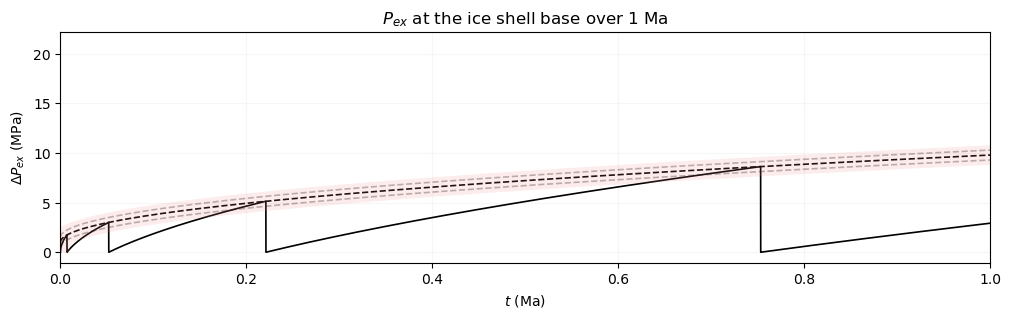

In [16]:
fig, ax = plt.subplots(figsize=(12,3))

ax.plot(ri_timed[:,1]/1e6, Pcrit/1e6, color = 'black', linestyle='dashed', lw = 1.2)
ax.plot(ri_timed[:,1]/1e6, (Pcrit+5e5)/1e6, color = 'black', linestyle='dashed', lw = 1.2, alpha = 0.3)
ax.plot(ri_timed[:,1]/1e6, (Pcrit-5e5)/1e6, color = 'black', linestyle='dashed', lw = 1.2, alpha = 0.3)

ax.plot(ri_timed[:,1]/1e6, np.array(dP_Pcrit[1:])/1e6, color = 'black', lw = 1.2)
ax.plot(ri_timed[:,1]/1e6, Pcrit/1e6, color = 'lightcoral', lw = 14, alpha=0.15, linestyle = 'solid')

ax.set_xlabel('$t$ (Ma)')
ax.set_ylabel('$\Delta P_{ex}$ (MPa)')
ax.grid(alpha=0.1)
ax.set_xlim(0,1)

ax.set_title("$P_{ex}$ at the ice shell base over 1 Ma")

Text(0.5, 1.0, '$P_{ex}$ at the ice shell base over 1 Ma')

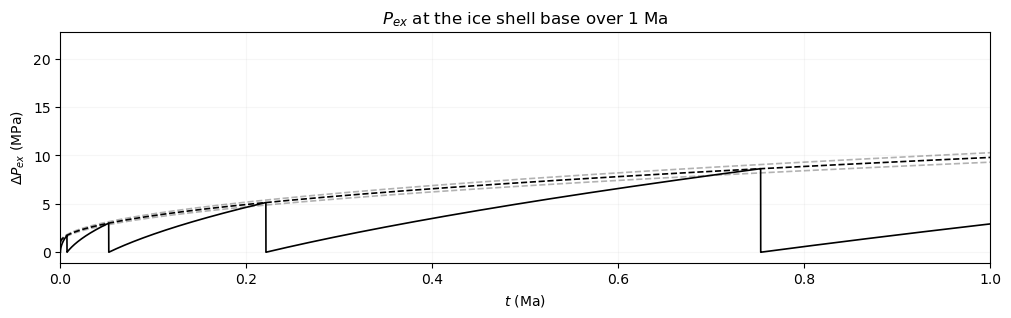

In [17]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(ri_timed[:,1]/1e6, Pcrit/1e6, color = 'black', linestyle='dashed', lw = 1.2)
ax.plot(ri_timed[:,1]/1e6, (Pcrit+Pcrit*0.05)/1e6, color = 'black', linestyle='dashed', lw = 1.2, alpha = 0.3)
ax.plot(ri_timed[:,1]/1e6, (Pcrit-Pcrit*0.05)/1e6, color = 'black', linestyle='dashed', lw = 1.2, alpha = 0.3)

ax.plot(ri_timed[:,1]/1e6, np.array(dP_Pcrit[1:])/1e6, color = 'black', lw = 1.2)

ax.set_xlabel('$t$ (Ma)')
ax.set_ylabel('$\Delta P_{ex}$ (MPa)')
ax.grid(alpha=0.1)
ax.set_xlim(0,1)

ax.set_title("$P_{ex}$ at the ice shell base over 1 Ma")

In [18]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
	ax = ax if ax is not None else plt.gca()
	if color is None:
		color = ax._get_lines.get_next_color()
	if np.isscalar(yerr) or len(yerr) == len(y):
		ymin = y - yerr
		ymax = y + yerr
	elif len(yerr) == 2:
		ymin, ymax = yerr
	ax.plot(x, y, color='indianred', lw = 1.3, linestyle = 'dashed')
	ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

Text(0.5, 1.0, '$P_{ex}$ at the ice shell base over 1 Ma')

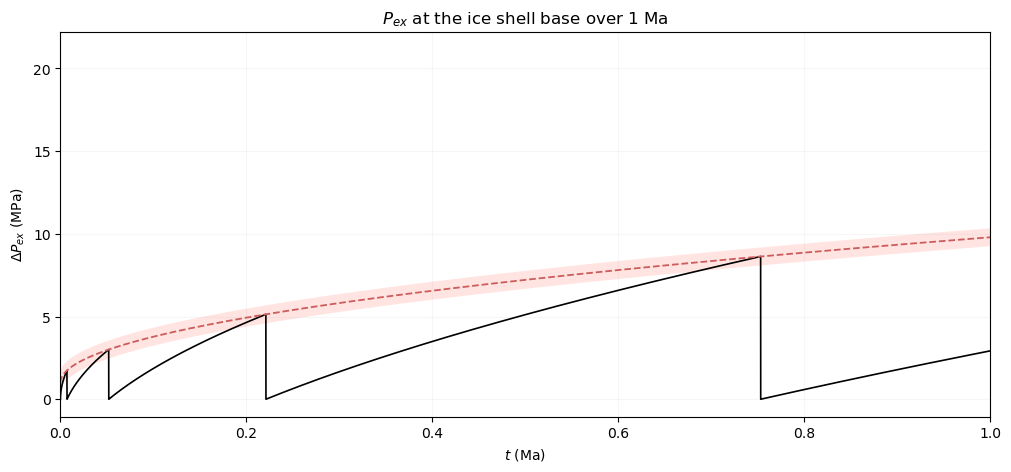

In [19]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(ri_timed[:,1]/1e6, np.array(dP_Pcrit[1:])/1e6, color = 'black', lw = 1.2)
errorfill(ri_timed[:,1]/1e6, Pcrit/1e6, 0.5, color ='mistyrose', alpha_fill=1)

ax.set_xlabel('$t$ (Ma)')
ax.set_ylabel('$\Delta P_{ex}$ (MPa)')
ax.grid(alpha=0.1)
ax.set_xlim(0,1)

ax.set_title("$P_{ex}$ at the ice shell base over 1 Ma")


In [20]:
# Reynolds number

# def Re(rhow, u, w, eta_w):
#     """
#     Calculates Reynolds number of fluid in the dike

#     Params:
#         rhow     : water density (kg/m3)
#         u        : velocity of fluid in dike (m/s)
#         w        : (m) horizontal half-length
#         viscosity: dynamic viscosity of fluid (Pa s)
    
#     Returns:
#         Re       : Reynolds number (adimensional)

#     """

#     Re = (rhow * np.abs(u * w)) / eta_w
#     return Re

# # divergence

# def div(ux, uy, uz, x, y, z):
#     """
#     Calculate the divergence of a 3D vector field u = (ux,uy,uz)
#     """
#     du_dx = np.gradient(ux, x, axis=0)
#     dv_dy = np.gradient(uy, y, axis=1)
#     dw_dz = np.gradient(uz, z, axis=2)
#     return du_dx + dv_dy + dw_dz

# # For your 1D case, this would simplify to:
# dwdt = np.gradient(u_lam * w_max, ri)

In [21]:
# dimensions and velocity



def h(rhow, rhoi, g, vel, dP_Pcrit, ri, R, Ph):
    """
    Calculates dike height

    Params:
        rhow : water density (kg/m3)
        rhoi : ice density (kg/m3)
        g    : gravitational acceleration (m/s2)
    
    Returns:
        h    : dike height (m)

    """
    h = (-1/2 * rhow * velocity(rhow, rhoi, g, ri, R, Ph, dP_Pcrit)**2 - dP_Pcrit + Ph) / ((rhow - rhoi) * g)
    return h


# def h(Kc, rhow, rhoi, g): # Manga & Wang (2007) maximum crack length
#     """
#     Calculates dike height

#     Params:
#         Kc   : fracture toughness (Pa m1/2)
#         rhow : water density (kg/m3)
#         rhoi : ice density (kg/m3)
#         g    : gravitational acceleration (m/s2)
#         a    : dimension of the region in which yielding occurs 
    
#     Returns:
#         h    : dike height (m)

#     """
#     a = w(Kc, rhoi, rhow, G, g) 
#     h = 1 / a * (2 * S / (rhoi * g))**2
#     return h


# # linearly decaying velocity with time

# def vel(L, tso):
#     """
#     Calculates velocity of fluid in the dike

#     Params:
#         L   : (m) vertical length of dike
#         tso : time since opening began (s)
    
#     Returns:
#         u   : velocity of fluid in dike (m/s)

#     """

#     u = L / tso
#     return u

In [22]:
# Pressures

########## buoyancy
def buoyancy(rhow, rhoi, g, ξ):
    """
    Calculates buoyancy stress at the base of the ice shell

    Params:
        rhow : water density (kg/m3)
        rhoi : ice density (kg/m3)
        g    : gravitational acceleration (m/s2)
        ξ    : ice shell thickness (m)
    
    Returns:
        Fb   : buoyancy stress (Pa)

    """

    Fb = (rhow - rhoi) * g * ξ
    return Fb

######### fracture pressure at dike tip
def fracture_pressure(Kc, thickness):
    """
    Calculates fracture pressure at the dike tip

    Params:
        Kc : fracture toughness (Pa m1/2)
        w  : (m) horizontal half-length
    
    Returns:
        Pf : pressure at dike tip (Pa)

    """

    Pf = Kc / np.sqrt(thickness/2)
    return Pf

######## elastic pressure
def elastic_pressure(G, nu, w_max):
    """
    Calculates elastic pressure at the dike tip

    Params:
        G  : shear modulus (Pa)
        nu : Poisson's ratio
        w_max  : (m) horizontal half-length
    
    Returns:
        Pe : elastic pressure at dike tip (Pa)

    """

    Pe = G * w_max / ((1 - nu) * w_max/2)
    return Pe



######## pressure drop
def pressure_drop(w, ot, tso):
    """
    Calculates pressure drop due to viscous flow in the dike

    Params:
        w   : (m) horizontal half-length
        ot  : opening width (m)
        tso : time since opening began (s)
    
    Returns:
        Pv  : viscous pressure drop (Pa)

    """

    Pv = 12 * (w/2)**2 / (ot * tso)
    return Pv


######## volumetric flux
def Q(w_max, h_max, dP_Pcrit):
    """
    Calculates volumetric flux in the dike

    Params:
        w_max    : (m) horizontal half-length
        h_max    : (m) vertical length of dike
        dP_Pcrit : excess pressure over critical pressure (Pa)
    
    Returns:
        Q  : volumetric flux (m3/s)

    """

    Q_val = w_max**3 / (12 * eta_w * h_max) * (dP_Pcrit + S - Kc/np.sqrt(h_max) + Ph(rhoi, g, h_max))
    return Q_val

In [23]:
def width(Kc, G, nu, w):
    """
    Calculates dike opening width

    Params:
        Kc : fracture toughness (Pa m1/2)
        G  : shear modulus (Pa)
        nu : Poisson's ratio
        w  : (m) horizontal half-length
    
    Returns:
        ot : opening width (m)

    """

    w = (elastic_pressure(G, nu, ot, w)*h)/()
    return w

In [24]:
# laminoturbulent velocity

# us = []

# for i in range(len(ri)):
#     if dP_Pcrit[i] == 0:
#         u = -(w**2)/(3 * eta_w) * del_p[i]
#         if Re(rhow, u, w, eta_w) < 1e3:
#             us.append(u)
#         elif Re(rhow, u, w, eta_w) >= 1e3:
#             u = - ((2*w)/(0.03*rhow*np.abs(del_p[i])))**0.5 * del_p[i]
#             us.append(u)
#     else:
#         vel_i = 0

In [25]:
# critical lengthscale as defined by Pansino et al. (2022), using Dahm (2000) and Menand & Tait (2002)

# Lbf = 2 * ( Kc / ( (rhow - rhoi) * g * np.sqrt(np.pi) ) )**(2/3)
# Lbf # units do not make sense

In [26]:
# fracture times

# times since opening of fracture
tso = []
t_last = 0
for i in range(len(ri)):
    if dP_Pcrit[i] == 0:
        t = ri_timed[i,1]/1e6 - t_last
        print(f"fracture and P release at t = {t:.2} Ma")
        tso.append(t)
        t_last = t

tso # in Ma

fracture and P release at t = 0.0 Ma
fracture and P release at t = 0.0072 Ma
fracture and P release at t = 0.045 Ma
fracture and P release at t = 0.18 Ma
fracture and P release at t = 0.58 Ma
fracture and P release at t = 1.7 Ma


[0.0,
 0.007200031709791984,
 0.044899999999999995,
 0.17620003170979198,
 0.5769,
 1.6594000317097921]

In [27]:
# Michaut & Manga (2014) max velocity at the top of the dike
def velocity(rhow, rhoi, g, ri, R, Ph, dP_Pcrit):
    """
    Calculates max velocity at the top of the dike

    Params:
        rhow : water density (kg/m3)
        rhoi : ice density (kg/m3)
        g    : gravitational acceleration (m/s2)
    
    Returns:
        u : max velocity at the top of the dike (m/s)

    """

    u = (( 2 * ((Ph + dP_Pcrit) - (rhow - rhoi) * g * (R - ri)) ) / rhow ) **(1/2)
    return u

In [28]:
# velocity profile through time

us = []

for i in range(len(ri)):
    if dP_Pcrit[i] == 0:
        u = velocity(rhow, rhoi, g, ri[i], R, Phs[i], dP_Pcrit[i])
        print(f"max velocity at t = {ri_timed[i,1]/1e6:.2} Ma is {u} m/s")
    else:
        u = 0
    us.append(u)


max velocity at t = 0.0 Ma is [nan nan nan ... nan nan nan] m/s
max velocity at t = 0.0072 Ma is 35.672634769319004 m/s
max velocity at t = 0.052 Ma is 58.70819783316444 m/s
max velocity at t = 0.22 Ma is 84.298041696803 m/s
max velocity at t = 0.75 Ma is 114.53094337467796 m/s
max velocity at t = 2.2 Ma is 150.34986529550687 m/s


/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/93498271.py:16: RuntimeWarning: invalid value encountered in sqrt
  u = (( 2 * ((Ph + dP_Pcrit) - (rhow - rhoi) * g * (R - ri)) ) / rhow ) **(1/2)


In [29]:
# # now we compute the  flow rate, Q, in the dike over time

# Q = [] # flow rate at fracture time (m3/s)

# # Calculate the dike width once
# w_val = w(Kc, rhoi, rhow, G, g)

# for i in range(len(ri)):
#     if dP_Pcrit[i] == 0:

#         # Q_i = w_val**3 / (12 * eta_w * h(Kc, rhow, rhoi, g)) * (dP_Pcrit[i] + S - Kc/np.sqrt(h) + Ph(rhoi, g, R - ri[i]))
#         Q.append(Q_i)
#     else:
#         Q.append(0)

# np.max(Q) # m3/s

In [30]:
# max width and height

w_max = ((Kc**4 * (1-nu)**3) / ((rhow - rhoi) * g * G**3))**(1/3)
print(f"max half-width is {w_max*1e3:.2} mm")

h_max = (Kc / (rhow - rhoi) *  g)**(2/3)
print(f"max half-height: {h_max:.2f} m")

pf = Kc / np.sqrt(thickness/2)
print(f"max fracture pressure: {max(pf)/1e6:.2f} MPa")

# if K > Kc, fracture propagates
K = h_max**(1/2) * (np.array(dP_Pcrit[1:]))
print(f"max K is {max(K)/1e6:.2f} MPa m1/2 for each injection time")

# dike will propagate at its upper tip if dP_Pcrit > [...]
dP_thresh = (Kc / h_max**(1/2)) + (1/2) * np.array(Phs[1:])
print(f"max overpressure threshold is {max(dP_thresh)/1e6:.2f} MPa; max overpressure - threshold = {max(np.array(dP_Pcrit[1:]) - dP_thresh)/1e6:.2f} MPa")
# max half-height if dP_Pcrit > dP_thresh

# spacial pressure gradient
dPdz = np.gradient(np.array(dP_Pcrit[1:]), ri) 
dPdx = np.zeros(len(dPdz)) # no lateral pressure gradient

# laminar flow velocity
u_lam = -(w_max**2 * dPdz) / (3 * eta_w)
print(f"max laminar flow velocity is {max(u_lam):.2f} m/s")

# turbulent flow velocity (L&K Eq. 8b)
u_turb = -((2 * w_max) / (0.03 * rhow * np.abs(dPdz)))**(1/2) * dPdz
print(f"max turbulent flow velocity is {max(u_turb):.2f} m/s")

# variation in thickness with time (Rubin 1995 Eq. 5)
ux = -(w_max**2 * dPdx) / (3 * eta_w) # horizontal velocity component
uz = -((w_max**2) / (3 * eta_w)) * (dPdz - (rhow * g)) # vertical velocity component
dwdt = - np.gradient(ux, 2*w_max) - np.gradient(uz, ri)
# print(f"maximum dw/dt = {max(dwdt)*1e3*y2sec:.2e} mm/yr")
print(f"max horizontal velocity component is {max(ux):.2f} m/s")
print(f"max vertical velocity component is {max(uz):.2f} m/s")
print(f"max dw/dt = {max(dwdt):.2f} m/s")

# will the dike propagate? If K>Kc
K = elastic_pressure(G, nu, w_max) * w_max**(1/2)
print(f"max K is {K/1e6:.2f} MPa m1/2 for each injection time")
if K > Kc:
    print(f"the dike* WILL propagate, K > Kc by about {(K-Kc)/1e6:.0f} MPa m1/2 (a uniform bladelike fracture of size 2l)")

# variation of thickness with time
# dwdt = np.gradient(u_lam * w_max, ri)
# dwdt_y = dwdt * y2sec * 1e3 # mm/yr
# print(f"maximum variation of thickness with time is {max(dwdt_y):.2e} m/yr")




max half-width is 4.1 mm
max half-height: 526.02 m
max fracture pressure: 1.41 MPa
max K is 403.92 MPa m1/2 for each injection time
max overpressure threshold is 9.88 MPa; max overpressure - threshold = 7.74 MPa
max laminar flow velocity is 18.38 m/s
max turbulent flow velocity is 0.94 m/s
max horizontal velocity component is -0.00 m/s
max vertical velocity component is 25.76 m/s
max dw/dt = 325150.48 m/s
max K is 600.27 MPa m1/2 for each injection time
the dike* WILL propagate, K > Kc by about 599 MPa m1/2 (a uniform bladelike fracture of size 2l)


(0.0, 1.0)

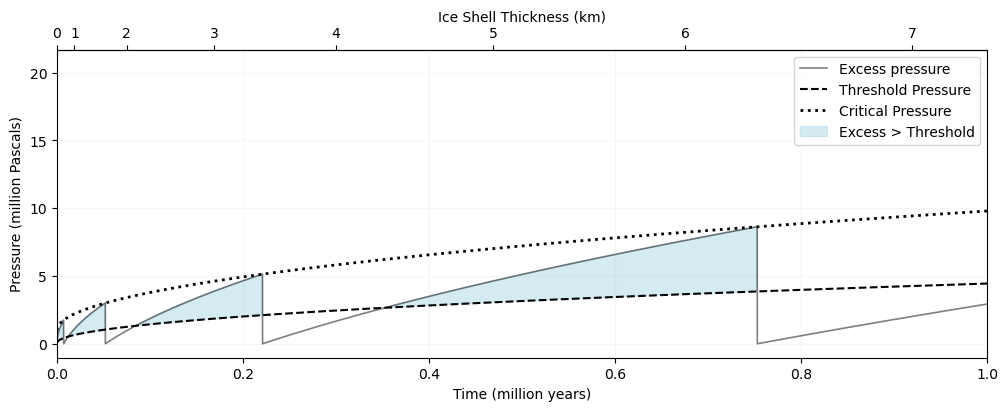

In [31]:
# Does the dike propagate? If dP_Pcrit > dP_thresh

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(ri_timed[:,1]/1e6, np.array(dP_Pcrit[1:])/1e6, color='black', lw=1.2, label='Excess pressure', alpha=0.5)
ax.plot(ri_timed[:,1]/1e6, dP_thresh/1e6, color ='black', lw = 1.5, linestyle = 'dashed', label = 'Threshold Pressure')
ax.plot(ri_timed[:,1]/1e6, Pcrit/1e6, color ='black', label='Critical Pressure', linestyle='dotted', lw = 2)

mask = np.array(dP_Pcrit[1:]) > dP_thresh
if np.any(mask):
    ax.fill_between(ri_timed[:,1] / 1e6, np.array(dP_Pcrit[1:]) / 1e6, dP_thresh/1e6, where = mask, 
                    color = 'lightblue', alpha = 0.5, label = 'Excess > Threshold')
    
def time2thick(t):
    return np.interp(t, ri_timed[:,1]/1e6, (R - ri_timed[:,0])/1e3)
def thick2time(th):
    return np.interp(th, (R - ri_timed[:,0])/1e3, ri_timed[:,1]/1e6)

ax2 = ax.secondary_xaxis('top', functions=(time2thick, thick2time))
ax2.set_xlabel('Ice Shell Thickness (km)')

ax.legend(loc='best')
ax.set_xlabel('Time (million years)')
ax.set_ylabel('Pressure (million Pascals)')
ax.grid(alpha=0.1)
ax.set_xlim(0,1)


In [32]:
# overpressure and fracture times

P_o = [] # in years and Pa
for i in range(len(ri)):
    if dP_Pcrit[i] == 0:
        P_0 = dP_Pcrit[i-1] - dP_thresh[i-1]
        if i > 0:
            print(f"overpressure = {P_0/1e6:.2f} MPa ({ri_timed[i,1]/1e6:.2f} Ma)")
        P_o.append([ri_timed[i,1], P_0])

Po = np.array(P_o[1:]) # exclude first entry where excess P is zero
Po[:,1]/1e6 # Pfracture[:,1] is overpressure (MPa)


overpressure = 1.32 MPa (0.01 Ma)
overpressure = 1.96 MPa (0.05 Ma)
overpressure = 3.02 MPa (0.22 Ma)
overpressure = 4.77 MPa (0.75 Ma)
overpressure = 7.53 MPa (2.24 Ma)


array([1.32186772, 1.95852142, 3.02285825, 4.77126798, 7.53138618])

In [33]:
# height of dike for which ΔPex = P_threshold
# h_thresh = []
# for i in range(len(Pfracture)):
#     h_threshs = (Kc / (Pfracture[i,1] + 0.5 * (rhow-rhoi) * g))**2
#     h_thresh.append(h_threshs)
#     print(f"max height of dike at P_threshold is {h_thresh[i]} m")

In [34]:
# Bernoulli -- max velocity at the top of the dike (Michaut & Manga 2014)

vm = []
thicks = []

for i in range(Po.shape[0]):
    thicknesses = np.interp(Po[i,0], ri_timed[:,1], R - ri_timed[:,0]) 
    # interpolation of overpressure, time, and thickness
    v_w = ( 2 * (Po[i,1] - (rhow - rhoi) * g * (thicknesses - (thicknesses * 0.1))) / (rhow) )**(1/2)
    vm.append(v_w)
    thicks.append(thicknesses)
    print(f"v_max = {v_w:.2f} m/s ({Po[i,0]/1e6:.2} Ma), thickness = {thicknesses/1e3:.2f} km")

v_max = 49.23 m/s (0.0072 Ma), thickness = 0.62 km
v_max = 58.33 m/s (0.052 Ma), thickness = 1.67 km
v_max = 70.95 m/s (0.22 Ma), thickness = 3.43 km
v_max = 87.84 m/s (0.75 Ma), thickness = 6.34 km
v_max = 109.30 m/s (2.2 Ma), thickness = 10.92 km


In [35]:
# dike thickness (Michaut & Manga 2014)

hs = np.array(thicks) * 0.9 # near-surface
w_MM = 2*(Po[:,1] * hs * (1 - nu) / G) # * 2 for full thickness

for i in range(len(w_MM)):
    print(f"w = {w_MM[i]:.2f} m ({Po[i,0]/1e6:.2f} Ma)")

w = 0.31 m (0.01 Ma)
w = 1.25 m (0.05 Ma)
w = 3.96 m (0.22 Ma)
w = 11.54 m (0.75 Ma)
w = 31.39 m (2.24 Ma)


In [36]:
# dynamic pressure at dike tip

Pd = 0.5 * rhow * np.array(vm)**2
Pd/1e6 # MPa

# is Pd > Pf?
for i in range(Po.shape[0]):
    # pf = Kc / (np.interp(Po[i,0], ri_timed[:,1], R - ri_timed[:,0]))**(1/2)
    w = Po[i,1] * np.interp(Po[i,0], ri_timed[:,1], R - ri_timed[:,0]) * (1 - nu / G)
    pf = Kc * np.sqrt( 2 / np.pi * w )

    print(f"at {Po[i,0]/1e6:.2f} Ma: Pd = {Pd[i]/1e6:.2f} MPa, Pf = {pf/1e6:.2} MPa")

    # if Pd[i] > pf:
    #     print(f"dynamic pressure {Pd[i]/1e6:.2f} MPa > fracture pressure {pf/1e6:.2f} MPa at {Po[i,0]/1e6:.2f} Ma")
    # else:
    #     print(f"dynamic pressure {Pd[i]/1e6:.2f} MPa < fracture pressure {pf/1e6:.2f} MPa at {Po[i,0]/1e6:.2f} Ma")


at 0.01 Ma: Pd = 1.24 MPa, Pf = 2.3e+04 MPa
at 0.05 Ma: Pd = 1.74 MPa, Pf = 4.6e+04 MPa
at 0.22 Ma: Pd = 2.58 MPa, Pf = 8.1e+04 MPa
at 0.75 Ma: Pd = 3.95 MPa, Pf = 1.4e+05 MPa
at 2.24 Ma: Pd = 6.12 MPa, Pf = 2.3e+05 MPa


/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/2127303225.py:7: RuntimeWarning: divide by zero encountered in divide
  dp_thresh = (Kc / h**(1/2)) + (1/2) * (rhow - rhoi) * g * h


Text(0.5, 0, 'Threshold Overpressure (MPa)')

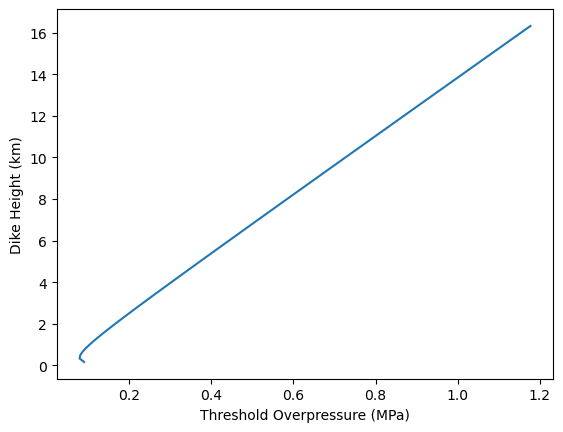

In [37]:
# a changing dp_thresh

# the higher in the ice shell, the larger the threshold pressure

h = np.linspace(0, max(thickness), 100) # (m) depth vector

dp_thresh = (Kc / h**(1/2)) + (1/2) * (rhow - rhoi) * g * h
plt.plot(dp_thresh/1e6, h/1e3)
plt.ylabel('Dike Height (km)')
plt.xlabel('Threshold Overpressure (MPa)')

In [38]:
# can the dike propagate with a changing dp_thresh?



/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/3371125394.py:8: RuntimeWarning: divide by zero encountered in divide
  dPe = G * w_eg / ((1 - nu) * h) # Pa (Taisne et al., 2011)
/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/3371125394.py:11: RuntimeWarning: invalid value encountered in sqrt
  b1 = (2 / np.pi) * (dPe * max(thickness) / (G/(1 - nu))) * np.sqrt(1 - ((w_eg**2 + h**2) / max(thickness)**2)) # (m) (Lister & Kerr, 1991)


Text(0.5, 0, 'Viscous Pressure Drop (MPa)')

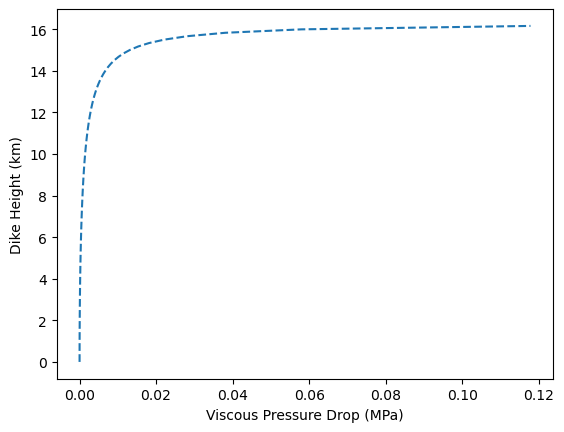

In [39]:
# pressure drop due to viscous flow
# Lister and Kerr (1991) + Taisne et al. (2011)

# normal stress required to open a crack

w_eg = 1 # (m) thickness of dike

dPe = G * w_eg / ((1 - nu) * h) # Pa (Taisne et al., 2011)

# horizontal breadth of dike
b1 = (2 / np.pi) * (dPe * max(thickness) / (G/(1 - nu))) * np.sqrt(1 - ((w_eg**2 + h**2) / max(thickness)**2)) # (m) (Lister & Kerr, 1991)

# pressure drop
dPv = eta_w * max(thickness) / (b1**2) * (60) # Pa (Lister & Kerr, 1991)

dPv = dPv[~np.isnan(dPv)] # ~ denotes not these
plt.plot(dPv/1e6, h[:-1]/1e3, linestyle = 'dashed')
plt.ylabel('Dike Height (km)')
plt.xlabel('Viscous Pressure Drop (MPa)')



In [40]:
dP_thresh

array([  44203.65133552,   44384.33233555,   87576.47089658, ...,
       9874876.75678982, 9874975.07495036, 9875073.39212777])

/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/3474996280.py:11: RuntimeWarning: invalid value encountered in sqrt
  b_i = (2 / np.pi) * (dPe * thicks[i] / (G/(1 - nu))) * np.sqrt(1 - ((w_eg**2 + hs**2) / thicks[i]**2)) # (m) (Lister & Kerr, 1991)


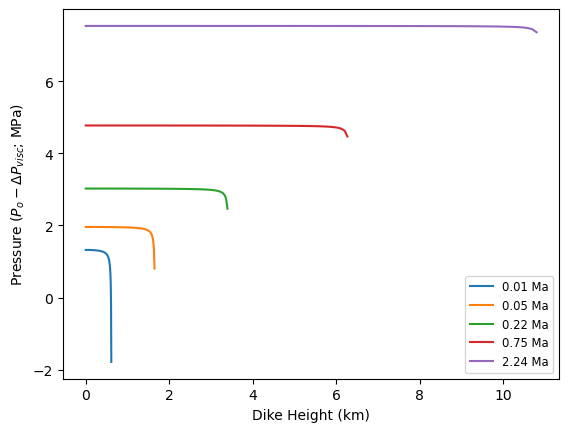

In [41]:
# applying the pressure drop to each overpressure

from matplotlib.offsetbox import PaddedBox

dp_visc = [] # P profile w/ P drop


for i in range(Po.shape[0]):
    # horizontal breadth of dike
    hs = np.linspace(0, thicks[i], 100) # (m) depth vector
    b_i = (2 / np.pi) * (dPe * thicks[i] / (G/(1 - nu))) * np.sqrt(1 - ((w_eg**2 + hs**2) / thicks[i]**2)) # (m) (Lister & Kerr, 1991)
    # pressure drop
    dPv_i = eta_w * thicks[i] / (b_i**2) * (60) # Pa (Lister & Kerr, 1991)
    dP_visc = - dPv_i + Po[i,1] # multiplying each p-drop by the ith pressure
    dp_visc.append(dP_visc)
    # pdb.set_trace()
    plt.plot(hs[:-1]/1e3, dP_visc[:-1]/1e6, linestyle = 'solid', label = f'{Po[i,0]/1e6:.2f} Ma')
    
# plt.plot(dP_thresh/1e6, hs[:-1]/1e3, color ='black', lw = 1.5, linestyle = 'dashed', label = 'Threshold Pressure')
dp_visc = np.array(dp_visc)

plt.ylabel('Pressure ($P_o - \Delta P_{visc}$; MPa)')
plt.xlabel('Dike Height (km)')
plt.legend(loc='best', fontsize='small')


`dp_visc` is essentially $\nabla P$, the pressure gradient used by Lister & Kerr (1991).

In [42]:
print()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


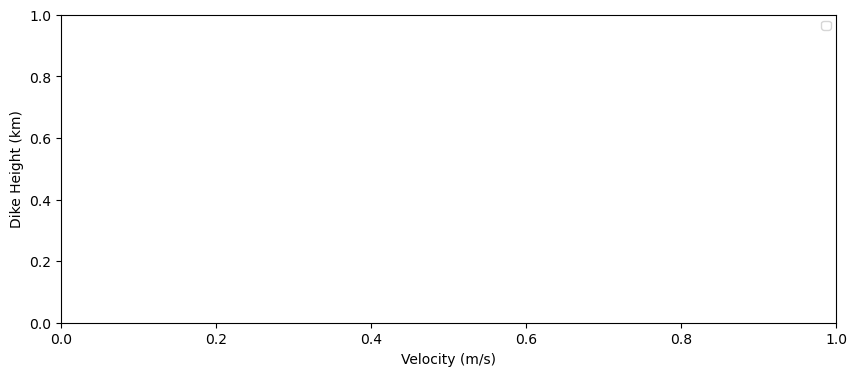

In [43]:
# velocity profile of the dike with dp_visc

fig, ax = plt.subplots(figsize=(10,4))

uL = []
uT = []
URe = []

# colors = cmo.amp(np.linspace(0, 1, dp_visc.shape[0]))
colors = ['royalblue', 'hotpink', 'darkorange', 'indianred']


for i in range(dp_visc.shape[0]):
    hs = np.linspace(0, thicks[i], 100) # (m) depth vector
    DP = dp_visc[i,:]
    w_example = 0.5 # (m) half-width
    # laminar
    ul = (2*w_example**2) / (3 * eta_w) * DP
    uL.append(ul)
    # turbulent
    ut = ((2 * w_example) / (0.03 * rhow * np.abs(DP)))**(1/2) * DP
    uT.append(ut)
    uRe = 7.7 * ( w_example**5 / (eta_w * rhow**3 * np.abs(DP)**3) )**(1/7) * DP
    URe.append(uRe)
    # plt.plot(ul, hs/1e3, color=colors[i], linestyle = 'solid', label = f'$v_L$, dike thickness = {thicks[i]/1e3:.2f} km')
    # plt.plot(ut, hs/1e3, color=colors[i], linestyle = 'dashed', label = f'$v_T$, dike thickness = {thicks[i]/1e3:.2f} km')
    # plt.plot(uRe, hs/1e3, color='black', linestyle = 'solid')
    # print(f"uRe = {max(uRe):.2f} m/s for dike thickness = {thicks[i]/1e3:.2f} km")

uL = np.array(uL)
uT = np.array(uT)
URe = np.array(URe)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Dike Height (km)')
plt.legend(loc='best', fontsize='small', ncol = 2)

# why are u so large??

In [44]:
w = 0.5 # (m) half-width
Re_w = (rhow * u * w) / eta_w
print(f"Re = {Re_w:.2e} for w = {w_example} m")

Re = 0.00e+00 for w = 0.5 m


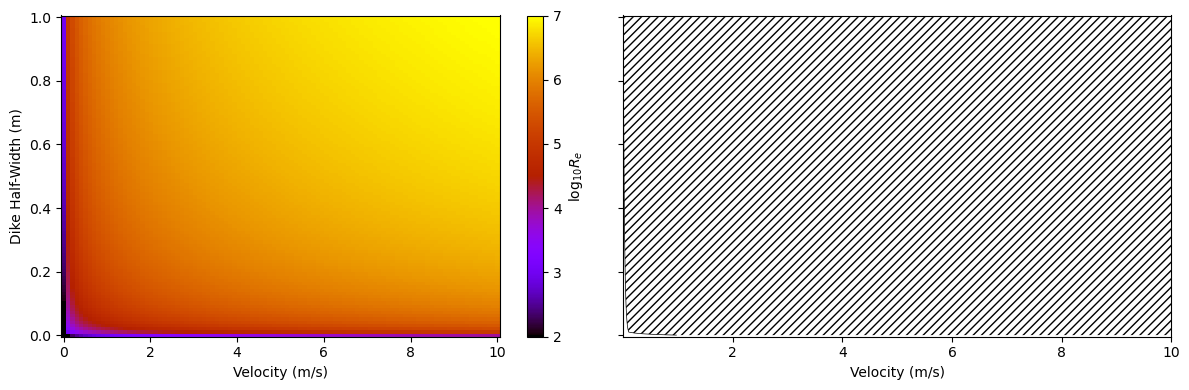

In [45]:
# Reynolds number for different dike geometries and velocities
# Re = ρuL/η

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), sharey=True)

ws = np.linspace(1e-3, 1, 100) # (m) half-widths
u = np.linspace(1e-3, 10, 100) # (m/s) velocities
u_w, w_u = np.meshgrid(u, ws)

Res = (rhow * u_w * w_u) / eta_w
logRe = np.log10(Res)

pcm = ax1.pcolormesh(u_w, w_u, logRe, shading='auto', vmax=7, vmin=2, cmap='gnuplot')
fig.colorbar(pcm, ax=ax1, label='log$_{10}R_e$')
ax1.invert_yaxis()
ax1.set_xlabel('Velocity (m/s)')
ax1.set_ylabel('Dike Half-Width (m)')

# ax2.pcolormesh(u_w, w_u, logRe, shading='auto', vmax=7, vmin=4, cmap='gnuplot')
ax2.contourf(u_w, w_u, logRe, levels=[3, logRe.max()], hatches = ['////'], colors = 'none')
ax2.contour(u_w, w_u, logRe, levels=[3], colors='black', linewidths=0.5)
ax2.invert_yaxis()
ax2.set_xlabel('Velocity (m/s)')
plt.tight_layout()

Text(0, 0.5, 'width, w (m)')

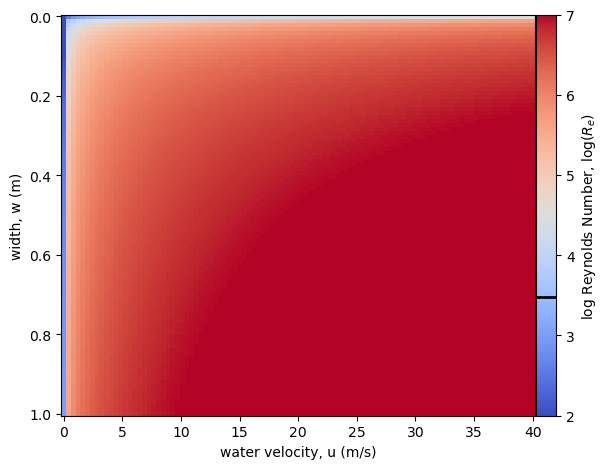

In [46]:
# Reynolds number for different dike geometries and velocities
# Re = ρuL/η

from numpy import pad

fig, ax = plt.subplots(layout='tight')

ws = np.linspace(1e-3, 1, 100) # (m) half-widths
u = np.linspace(1e-3, 40, 100) # (m/s) velocities
u_w, w_u = np.meshgrid(u, ws)

Res = (rhow * u_w * w_u) / eta_w
logRe = np.log10(Res)

pcm = ax.pcolormesh(u_w, w_u, logRe, shading='auto', vmax=7, vmin=2, cmap='coolwarm')
# plt.contour(u_w, w_u, logRe, levels=[3], colors='black', linewidths=0.8)
bar = fig.colorbar(pcm, label='log Reynolds Number, log($R_e$)', pad = 0.002)
bar.ax.hlines(3.48, *bar.ax.get_xlim(), colors='black', linewidth=2, linestyle='solid')
ax.invert_yaxis()
ax.set_xlabel('water velocity, u (m/s)')
ax.set_ylabel('width, w (m)')

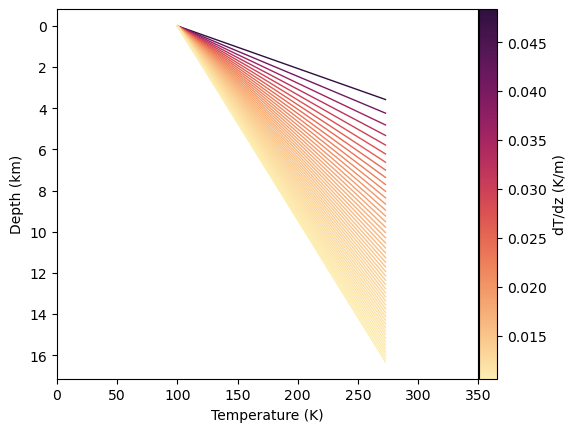

In [47]:

Ts = 100
Tb = 273
indx = np.linspace(2400, len(thickness) - 1, 50, dtype=int)
thicknesses = thickness[indx]
dTdz = (Tb - Ts) / thicknesses

fig, ax = plt.subplots()
cmap = plt.get_cmap('cmo.matter')
t_Ma = ri_timed[indx, 1] / 1e6
# norm = plt.Normalize(vmin=t_Ma.min(), vmax=t_Ma.max())
norm = plt.Normalize(vmin=np.min(dTdz), vmax=np.max(dTdz)
                     )
for i in range(50):
    ax.plot([Ts, Tb], [0, thicknesses[i]/1e3], color = cmap(norm(dTdz[i])), 
            linewidth=1)   
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad = 0.001)
cbar.set_label('dT/dz (K/m)')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Depth (km)')
ax.tick_params(axis='x')
ax.set_xlim(0, 350)
ax.invert_yaxis()

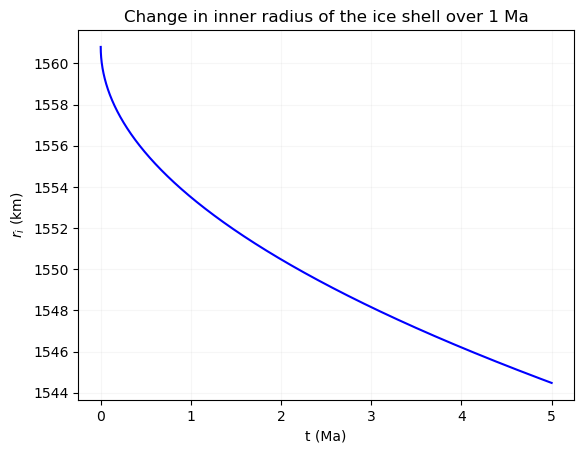

In [48]:
fig, ax = plt.subplots()

ax.plot(ri_timed[:,1]/1e6, ri_timed[:,0]/1e3, color = 'blue')
ax.set_xlabel('t (Ma)')
ax.set_ylabel('$r_i$ (km)')
ax.set_title('Change in inner radius of the ice shell over 1 Ma')
ax.grid(alpha=0.1)

In [49]:
# dike geometries and pressures

# pcrit = []
# l = np.linspace(0, 1, 100)
# for i in range(100):
#     p_crits = Pcrit * l[i]
#     pcrit.append(p_crits)

# fig, ax = plt.subplots(figsize=(10,4)) 

# Pseries = np.linspace(0, len(Pcrit) - 1, 100, dtype=int)
# pcrit = Pcrit[Pseries] 

# ws = np.linspace(1e-3, 1, 100)
# h = np.linspace(1, np.max(thicks), 100)
# wh = ws/h
# p = np.linspace(1e4, 1e6, 100) # pressures from Michaut & Manga (2014)
# P, WH = np.meshgrid(pcrit, wh)

# # Q = WH**3 * (rhow - rhoi) * g / eta_w # Lister & Kerr (1991) 
# Q = u_w * ws * h # here, h is a placeholder for lateral breadth, because I'm assuming they are roughly equivalent 

# plt.contourf(WH, P/1e6, Q/1e3, levels=50, cmap='cmo.dense')
# cbar = plt.colorbar(label='Volumetric flux, Q (km$^3$/s)')
# # cbar.ax.invert_yaxis()
# plt.ylabel('Critical pressure, $P_{crit}$  (MPa)')
# plt.xlabel('w/h')



In [50]:
# fig, ax = plt.subplots(figsize=(10,4)) 

# Pseries = np.linspace(0, len(Pcrit) - 1, 100, dtype=int)
# pcrit = Pcrit[Pseries] 

# h = np.linspace(1, np.max(thicks), 100)
# ws = (rhow - rhoi) * np.max(thicks) / m * ( 1 - (h**2) / (np.max(thicks)**2) )**0.5
# wh = ws/h
# p = np.linspace(1e4, 1e6, 100) # pressures from Michaut & Manga (2014)
# P, WH = np.meshgrid(pcrit, wh)
# # Q = WH**3 * (rhow - rhoi) * g / eta_w # Lister & Kerr (1991) 
# Q = u_w * ws * h # here, h is a placeholder for lateral breadth, because I'm assuming they are roughly equivalent 

# plt.contourf(WH, P/1e6, Q/1e3, levels=100, cmap='cmo.deep_r')
# cbar = plt.colorbar(label='Volumetric flux, Q (km$^3$/s)')
# # cbar.ax.invert_yaxis()
# plt.ylabel('Critical pressure, $P_{crit}$  (MPa)')
# plt.xlabel('w/h')
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))


In [51]:
Kc

1000000.0

/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/2028821069.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(w_sil/h, DP_sil/1e6,label='silicic dike', color='black', linestyle='dashed')
/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/2028821069.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.plot(w_ice/h, DP_sil/1e6, label='glacial dike', color='deepskyblue', alpha = 1)


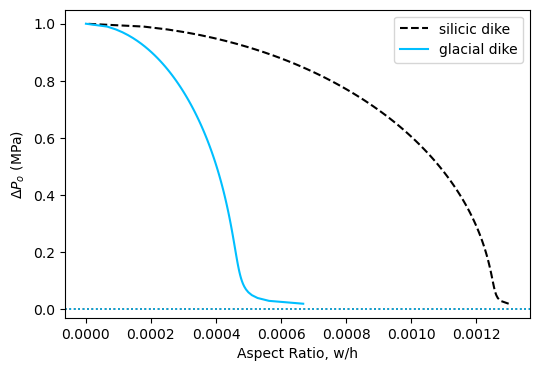

In [52]:
# 2D aspect ratio of silicate and ice shell dikes

# SILICATE
m_sil = 20e9 # Pa
DP_sil = np.linspace(1e4, 1e6, 100) # Pa
Drho_sil = 300 # kg/m3
Kc_sil = 20e6 # Pa m1/2
w_sil = (np.max(h)/m_sil) * (DP_sil + 0.5 * (300) * 9.81 * h) * (1 - (h**2 / np.max(h)**2))**0.5

# ICE
w_ice = (np.max(h)/m) * (DP_sil + 0.5 * (delta_rho) * g * h) * (1 - (h**2 / np.max(h)**2))**0.5

propagation_threshold_sil = Kc_sil / (np.max(h)**0.5 -  0.5 * (300) * 9.81 * np.max(h))
propagation_threshold_ice = Kc / (np.max(h)**0.5 -  0.5 * (delta_rho) * g * np.max(h))


plt.figure(figsize=(6,4))
plt.plot(w_sil/h, DP_sil/1e6,label='silicic dike', color='black', linestyle='dashed')
plt.plot(w_ice/h, DP_sil/1e6, label='glacial dike', color='deepskyblue', alpha = 1)
plt.axhline(propagation_threshold_sil/1e6, color='black', linestyle='dotted', lw=1.2)
plt.axhline(propagation_threshold_ice/1e6, color='deepskyblue', linestyle='dotted', lw=1.2)
plt.ylabel('$ΔP_o$ (MPa)')
plt.xlabel('Aspect Ratio, w/h')
plt.legend(loc='best')



In [53]:
print(f"An inspection of values")
print(f"Kc_sil = {Kc_sil/1e6:.2f} MPa m1/2 \nKc_ice = {Kc/1e6:.2f} MPa m1/2 \nsilicic prop thresh = {propagation_threshold_sil/1e6:.2f} MPa \nice prop thresh = {propagation_threshold_ice/1e6:.2f} MPa  ")


An inspection of values
Kc_sil = 20.00 MPa m1/2 
Kc_ice = 1.00 MPa m1/2 
silicic prop thresh = -0.00 MPa 
ice prop thresh = -0.00 MPa  


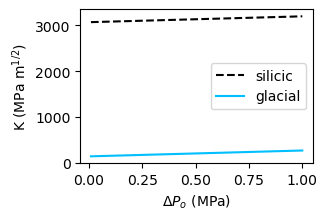

In [54]:
# evolution of K values

K_sil = np.max(h)**(1/2) * (DP_sil + 0.5 * (300) * 9.81 * np.max(h))
K_ice = np.max(h)**(1/2) * (DP_sil + 0.5 * (delta_rho) * g * np.max(h))

plt.figure(figsize=(3,2))
plt.plot(DP_sil/1e6, K_sil/1e6,label='silicic', color='black', linestyle='dashed')
plt.plot(DP_sil/1e6, K_ice/1e6, label='glacial', color='deepskyblue', alpha = 1)
plt.ylabel('K (MPa m$^{1/2}$)')
plt.xlabel('$ΔP_o$ (MPa)')
plt.legend(loc='best')

In [55]:
DP_uz = np.linspace(1e4, 1e6, 100)
(2*(DP_uz + (delta_rho) * g * np.max(thickness)) / rhow )**0.5

array([67.71251243, 67.85644063, 68.00006419, 68.14338504, 68.28640509,
       68.42912622, 68.5715503 , 68.71367917, 68.85551467, 68.9970586 ,
       69.13831276, 69.27927891, 69.41995881, 69.5603542 , 69.7004668 ,
       69.8402983 , 69.9798504 , 70.11912476, 70.25812303, 70.39684686,
       70.53529785, 70.67347761, 70.81138773, 70.94902979, 71.08640533,
       71.22351591, 71.36036304, 71.49694824, 71.63327302, 71.76933885,
       71.9051472 , 72.04069953, 72.17599728, 72.31104189, 72.44583476,
       72.5803773 , 72.7146709 , 72.84871694, 72.98251677, 73.11607176,
       73.24938324, 73.38245253, 73.51528096, 73.64786983, 73.78022042,
       73.91233402, 74.0442119 , 74.17585531, 74.3072655 , 74.4384437 ,
       74.56939115, 74.70010904, 74.8305986 , 74.960861  , 75.09089743,
       75.22070906, 75.35029706, 75.47966257, 75.60880674, 75.7377307 ,
       75.86643558, 75.99492248, 76.12319251, 76.25124676, 76.37908632,
       76.50671227, 76.63412567, 76.76132759, 76.88831906, 77.01

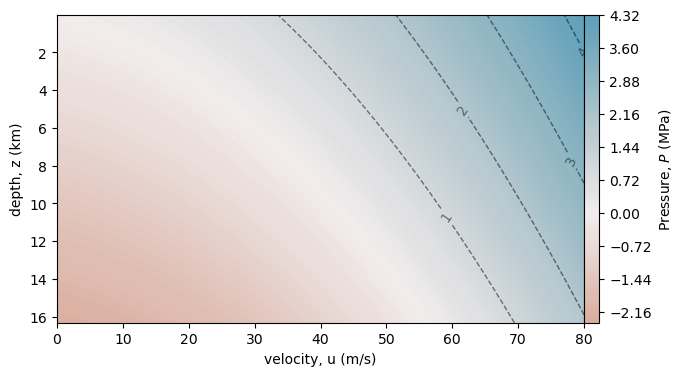

<Figure size 800x400 with 0 Axes>

In [56]:
# velocity and depth with pressure change

DP_uz = np.linspace(1e4, 1e6, 100)
u = np.linspace(0, 80, 100) # velocity
# u = (2*(DP_uz + (delta_rho) * g * np.max(thickness)) / rhow )**0.5
# z = np.linspace(0,8e3, 100) # depth
z = thickness # depth
U, Z = np.meshgrid(u, z)
DPh = delta_rho * g * Z
Pstatic = DP_uz - DPh 
Pdyn = 0.5 * rhow * U**2
P_tot = Pstatic + Pdyn
prop_boundary = Kc/(Z**0.5) - 0.5*DPh

fig, ax1 = plt.subplots(figsize=(8,4))

plt.figure(figsize=(8,4))
# plt.contourf(U, Z/1e3, np.log10(P_tot), levels=100, cmap=cmo.turbid_r)
# cbar = plt.colorbar(label='log-pressure, log($P$) (MPa)')
# cont = plt.contour(U, Z/1e3, np.log10(P_tot), levels=10, colors='black', alpha = 0.5, linewidths=0.7, linestyles='dashed')

pcm = ax1.contourf(U, Z/1e3, P_tot/1e6, cmap=cmo.balance_r, vmin=-11, vmax=11, levels = 100)
cbar = fig.colorbar(pcm, ax=ax1, label='Pressure, $P$ (MPa)', pad=0)
# cbar = fig.colorbar(pcm, ax=ax1, label='Pressure, $P$ (MPa)', pad=0, ticks=[1, 2, 3, 4, 5, 6])
cont = ax1.contour(U, Z/1e3, P_tot/1e6, levels= [1, 2, 3, 4, 5, 6], colors='black', alpha = 0.5, linewidths = 1, linestyles = 'dashed')
# cbar.add_lines(cont)
ax1.clabel(cont, inline=True, fontsize=10, fmt='%1.0f')
# ax1.contour(U, Z/1e3, (P_tot - prop_boundary)/1e6, levels=[0], colors='red', linewidths=0.7, linestyles='solid')
# PB = plt.contourf(U, Z/1e3, prop_boundary/1e6, levels=10, linewidths=1.5, cmap='Greys', alpha = 0.3)
# cbar2 = plt.colorbar(PB, label='propagation boundary (MPa)', pad=0.05)
ax1.set_ylabel('depth, z (km)')
ax1.set_xlabel('velocity, u (m/s)')
ax1.invert_yaxis()


In [57]:
# Luju's
# arg = P - drho * gE .* Z;
# U   = NaN(size(arg));
# valid = arg > 0;
# U(valid) = sqrt( (2./rho_w) .* arg(valid) );

In [58]:
# # velocity and depth with pressure change

# DP_uz = np.linspace(1e4, 1e6, 100)
# # Pstatic = DP_uz + delta_rho * g * np.max(thickness)
# # z = Pstatic - DP_uz / (delta_rho * g)
# te = np.linspace(0, np.max(thickness), 100)
# Pstatic = DP_uz + delta_rho * g * te
# z = Pstatic / (delta_rho * g)
# DP_mesh, Z_mesh = np.meshgrid(DP_uz, z)
# DP = DP_mesh - (delta_rho * g * (np.max(thickness) - Z_mesh))

# u_sq = 2/rhow * DP
# U = np.zeros_like(u_sq)
# valid = u_sq >= 0 
# U[valid] = np.sqrt(u_sq[valid])

# fig, ax1 = plt.subplots(figsize=(8,4))

# pcm = ax1.contourf(U, Z_mesh/1e3, np.log10(DP_mesh), cmap=cmo.speed, levels = 50)
# cbar = fig.colorbar(pcm, ax=ax1, label='log overpressure, $log(\Delta P_o)$ (Pa)', pad=0)
# ax1.set_ylabel('depth, z (km)')
# ax1.set_xlabel('velocity, u (m/s)')
# ax1.invert_yaxis()


In [59]:
print(f"SHAPES \nZ_mesh = {Z_mesh.shape}, \nU = {U.shape}, \nDP_mesh = {DP_mesh.shape}")

NameError: name 'Z_mesh' is not defined

In [141]:
Ws[-1]

array([0.00000000e+00, 1.31365315e-03, 4.50718927e-03, 9.58060835e-03,
       1.65339104e-02, 2.53670954e-02, 3.60801633e-02, 4.86731143e-02,
       6.31459481e-02, 7.94986650e-02, 9.77312648e-02, 1.17843748e-01,
       1.39836113e-01, 1.63708362e-01, 1.89460494e-01, 2.17092508e-01,
       2.46604406e-01, 2.77996186e-01, 3.11267850e-01, 3.46419396e-01,
       3.83450826e-01, 4.22362138e-01, 4.63153333e-01, 5.05824412e-01,
       5.50375373e-01, 5.96806217e-01, 6.45116944e-01, 6.95307555e-01,
       7.47378048e-01, 8.01328424e-01, 8.57158683e-01, 9.14868825e-01,
       9.74458850e-01, 1.03592876e+00, 1.09927855e+00, 1.16450822e+00,
       1.23161778e+00, 1.30060722e+00, 1.37147654e+00, 1.44422575e+00,
       1.51885484e+00, 1.59536381e+00, 1.67375266e+00, 1.75402140e+00,
       1.83617002e+00, 1.92019852e+00, 2.00610691e+00, 2.09389518e+00,
       2.18356333e+00, 2.27511137e+00, 2.36853929e+00, 2.46384709e+00,
       2.56103477e+00, 2.66010234e+00, 2.76104979e+00, 2.86387712e+00,
      

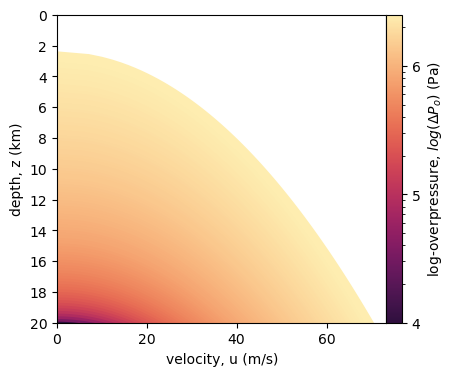

In [267]:
DP = np.linspace(1e4, 2.5e6, 100) # change factors of overpressure
max_depth = 20e3
fig, ax1 = plt.subplots(figsize=(5,4))
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
cmap = plt.get_cmap(cmo.matter_r)
DP_norm = LogNorm(vmin=np.min(DP), vmax=np.max(DP))
fig.subplots_adjust(wspace=0.1) # Remove space between plots
velocities = []
os = []
Ws = []

for dp in DP:
    deltarho = delta_rho
    Pgrad = deltarho * g
    LNB = dp / (deltarho * g)
    h_max = np.linspace(0, LNB, 100)
    w = dp * h_max / m  # M&M dike width (Eqn. 4)
    p = dp - deltarho * g * h_max
    p[p < 0] = 0
    # M&M dike velocity (Eqn. 3)
    u = np.sqrt(2 * p / rhow) # M&M dike velocity (Eqn. 3)
    # L&K turbulent dike velocity (Eqn. 8b)
    # u_turb = 7.7*((w**5) / (eta_w * rhow**3 * (np.abs(Pgrad))**3))**(1/7) * np.abs(Pgrad)
    z = max_depth - h_max
    overshoot = (m * w / (deltarho * g))**(1/2)
    z_os = z - overshoot
    u[p == 0] = 0
    # q = u * w * LNB # for a dike of breath approximated by its height
    ax1.plot(u, z/1e3, color=cmap(DP_norm(dp)), linewidth=4)
    # ax1.plot(u, z_os/1e3, color='black', linewidth=4)
    velocities.append(u)
    os.append(overshoot)
    Ws.append(w)
    # ax2.plot(w, z/1e3, q / 1e3, color= 'black')

velocities = np.array(velocities)

ax1.set_xlabel('velocity, u (m/s)')
ax1.set_ylabel('depth, z (km)')
ax1.invert_yaxis()
ax1.set_xlim(left=0)
ax1.set_ylim(bottom=20, top=0)
# ax1.set_yticks(np.arange(0, 20, 4))  # ticks at every km
ax1.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# ax2.set_xlabel('width, w (m)')
# ax2.set_ylabel('volumetric flux, Q (km$^3$/s)')
# ax2.set_xlim(left=0)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=DP_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1, pad = 0)
ticks = [1e4, 1e5, 1e6]
tick_labels = [r'4', r'5', r'6']
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label('log-overpressure, $log(\Delta P_o)$ (Pa)')


In [ ]:
os = np.array(os)
o

array([9.89722998, 9.84711711, 9.79674789, 9.74611836, 9.69522445,
       9.64406196, 9.59262659, 9.54091394, 9.48891947, 9.43663853,
       9.38406632, 9.33119792, 9.27802826, 9.22455215, 9.17076422,
       9.11665894, 9.06223064, 9.00747346, 8.95238136, 8.89694813,
       8.84116734, 8.78503237, 8.7285364 , 8.67167237, 8.61443298,
       8.55681071, 8.49879776, 8.44038609, 8.38156735, 8.32233292,
       8.26267385, 8.20258088, 8.1420444 , 8.08105444, 8.01960067,
       7.95767232, 7.89525824, 7.83234681, 7.76892596, 7.70498309,
       7.64050511, 7.57547836, 7.50988856, 7.44372086, 7.37695968,
       7.30958877, 7.24159112, 7.1729489 , 7.10364342, 7.03365508,
       6.96296328, 6.89154638, 6.81938161, 6.74644495, 6.67271109,
       6.59815332, 6.52274338, 6.44645136, 6.36924556, 6.29109235,
       6.21195596, 6.13179834, 6.05057888, 5.96825424, 5.88477804,
       5.80010056, 5.7141684 , 5.62692406, 5.53830554, 5.44824579,
       5.35667212, 5.26350549, 5.16865979, 5.07204081, 4.97354

/var/folders/4y/tw1pwdb527z5vwkr7_zjbgvw0000gn/T/ipykernel_4136/844193401.py:20: UserWarning: The following kwargs were not used by contour: 'label'
  cont = ax.contour(u_w, w_u, logRe, levels=[6], colors='black', linewidths=1, linestyles='dashed', label='log($R_e$) = 6')


(0.0, 70.01913944132158)

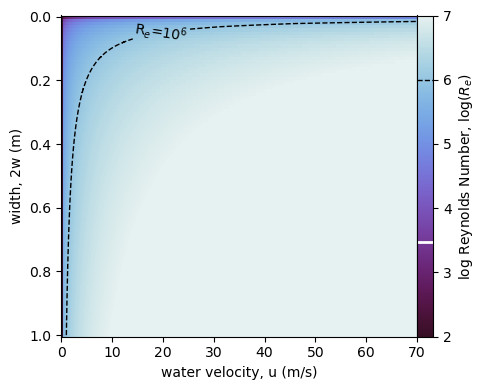

In [461]:
# Reynolds number for different dike geometries and velocities
# Re = ρuL/η
from labellines import labelLines

fig, ax = plt.subplots(layout='tight', figsize=(5,4))

ws = np.linspace(1e-3, 1, 100) # m, half-widths
u = velocities.flatten() # m/s, velocities
u = u[np.isfinite(u)]
u = u[u > 0]
u = np.sort(u)
u_w, w_u = np.meshgrid(u, ws)

Res = (rhow * u_w * w_u) / eta_w
Res[Res <= 0] = np.nan
logRe = np.log10(Res)

pcm = ax.pcolormesh(u_w, w_u, logRe, shading='auto', vmax=7, vmin=2, cmap=cmo.dense_r)
# plt.contour(u_w, w_u, logRe, levels=[3], colors='white', linewidths=0.8)
cont = ax.contour(u_w, w_u, logRe, levels=[6], colors='black', linewidths=1, linestyles='dashed', label='log($R_e$) = 6')
ax.clabel(cont, fmt={6: r'R$_e$=10$^6$'}, inline=True, manual=[(20, 0.1)])
bar = fig.colorbar(pcm, label='log Reynolds Number, log($R_e$)', pad = 0)
bar.ax.hlines(3.48, *bar.ax.get_xlim(), colors='white', linewidth=2, linestyle='solid')
bar.ax.hlines(6, *bar.ax.get_xlim(), colors='black', linewidth=1, linestyle='dashed')
ax.invert_yaxis()
ax.set_xlabel('water velocity, u (m/s)')
ax.set_ylabel('width, 2w (m)')
ax.set_xlim(left=0)

In [256]:
# plotting w and Q for dike of breadth ~ h_max

# for dp in DP:
#     LNB = dp / (delta_rho * g)
#     h_max = np.linspace(0, LNB, 100)
#     w = DP_uz * h_max / m  # M&M dike width (Eqn. 4)
#     p = dp - delta_rho * g * h_max
#     p[p < 0] = 0
#     u = np.sqrt(2 * p / rhow)
#     z = max_depth - h_max
#     q = u * w * LNB # for a dike of breath approximated by its height
#     plt.plot(q/1e3, w, label='q')

# plt.xlabel('volumetric flux, Q (km$^3$/s)')
# plt.ylabel('width, w (m)')
# plt.xlim(left=0)
# plt.ylim(bottom=0)

```python 
# Pansino et al (2022)
B = np.linspace(1e4, 1e5, 100) # breadth of dike
Q_grid = (B * max_depth * eta_w * Res) / (rhow * W)

# Francke and Thorade (2010) 
lambda_FT = (0.309) / np.log10(Res / 7)
dp1 = lambda_FT * max_depth / W 
dp2 = rhow * (velocities**2) / 2
DP_FT = dp1 * dp2
DP_i = np.min(DP_FT)
DP_o = np.max(DP_FT)
Q_grid = ( W * h**3) / (12 * eta_w) * (( DP_o - DP_i ) / max_depth)

colors = plt.contourf(Z/1e3, 2*W, Q_m3, levels=100, cmap='cmo.dense')
cont = plt.contour(Z/1e3, 2*W, Q_m3, levels=5, colors='white', linewidths=1, linestyles='dashed')
cbar = plt.colorbar(colors, label='Volumetric Flux, Q (m$^3$s$^{-1}$)')
# cbar.add_lines(cont)
ax1.clabel(cont, inline=True, fontsize=10, fmt=r'10$^{%.e}$')
plt.ylabel('2w (m)')
plt.xlabel('z (km)')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.contour(Z/1e3, 2*W, logQ, levels=[2], colors='red', linewidths=1, linestyles='solid')
```

<a list of 5 text.Text objects>

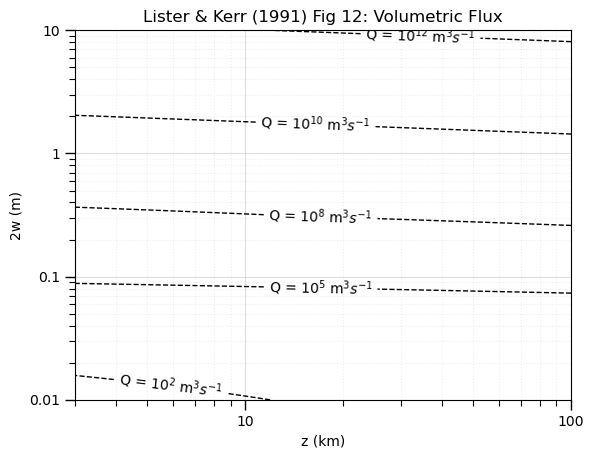

In [143]:
max_depth = 100e3
z = np.logspace(np.log10(3000), np.log10(max_depth), 100)  # meters, log-spaced
w = np.linspace(0.005, 5, 100) 
W, Z = np.meshgrid(w, z)

# Lister and Kerr (1991) ~~~ orders of mag: 6-9 
q1 = ((2 * W)/ (0.904))**10
q2 = (((-delta_rho) * g)**2 * Z * m) / (eta_w**3)
Q_grid = (q1 * q2)**(1/3)
logQ = np.log10(Q_grid)
Q_m3 = Q_grid
Q_km3 = Q_m3/1e9 # km3/s

fig, ax = plt.subplots()
# colors = plt.contourf(Z/1e3, 2*W, logQ, levels=100, cmap='cmo.dense')
cont = ax.contour(Z/1e3, 2*W, logQ, levels=4, colors='black', linewidths=1, linestyles='dashed')
# cbar = plt.colorbar(colors, label='log Volumetric Flux, Q (m$^3$/s)')
# cbar.set_ticks(np.arange(np.ceil(np.nanmin(logQ)), np.floor(np.nanmax(logQ)) + 1))
# cbar.set_ticklabels([fr'{int(i)}' for i in ticks]) # fr makes raw strings
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_ylabel('2w (m)')
ax.set_xlabel('z (km)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('z (km)')
ax.set_ylabel('2w (m)')
# ax.set_xlim(3, (Z/1e3).max())
# ax.set_ylim((2*W).min(), (2*W).max())
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=7, width=1)
ax.tick_params(which='minor', length=4, width=0.8)
ax.grid(which='major', alpha=0.4)
ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.set_title('Lister & Kerr (1991) Fig 12: Volumetric Flux')
ax.clabel(cont, inline=True, fontsize=10, fmt=r'Q = 10$^{%.0f}$ m$^3s^{-1}$')

<a list of 4 text.Text objects>

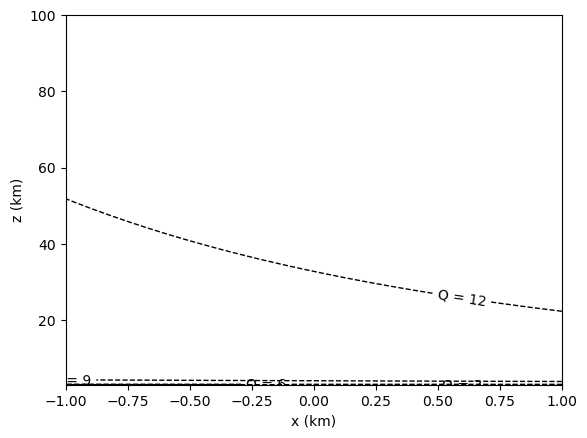

In [ ]:
# Lateral Q gradients (W, adimensional width)
# NOTE: Attempt to depict lateral variation in Q [needs work]
x_sample = 1e3
z = np.logspace(np.log10(3000), np.log10(max_depth), 100)
# x = np.linspace(-np.log10(x_sample), np.log10(x_sample), 100)
x = np.linspace(-x_sample, x_sample, 100) 
Z, X = np.meshgrid(z, x)
ksi = 0.381 * X * ( (-delta_rho * g)**4  / (Q_m3 * eta_w * m**3 * Z**3) )**(1/10)
W = (1 - ksi**2)**(3/2)
w = 0.904 * ( Q_m3**3 * eta_w**3 / ( (-delta_rho * g)**2 * Z * m) )**(1/10) * W
Q = ( (w / (0.904 * W) )**10 * ( (-delta_rho * g)**2 * Z * m) / (eta_w**3) )**(1/3)
logQ_36 = np.log10(Q)

contour = plt.contour(X/1e3, Z/1e3, logQ_36, levels=3, colors='black', linewidths=1, linestyles='dashed')
plt.xlabel('x (km)')
plt.ylabel('z (km)')
ax.clabel(contour, inline=True, fontsize=10, fmt='Q = %.0f')

### Eq. 47
$\alpha H^3 - \frac{5\alpha -3}{11}(ξH^3)^{\prime} = (H^7 H^{\prime})^{\prime}$, where $H(1)=0$ or $\lim_{ξ\rightarrow 1}H(ξ) = 0$

$ k=\frac{5\alpha -3}{11}$

$
\alpha H^{3} - \frac{5 \alpha + 3}{11} \left( \xi H^{3} \right)' = \left( H^{7} H' \right)'
$

$\alpha H^3 - k(ξH^3)^{\prime} = (H^7 H^{\prime})^{\prime}$

product rule: $(ξH^3)^{\prime}=\left( H^{3} + 3 \xi H^{2} H' \right)$ and 
$(H^7 H^{\prime})^{\prime}=7 H^{6} (H')^{2} + H^{7} H''$

$\alpha H^{3} - k\left( H^{3} + 3 \xi H^{2} H' \right) = 7 H^{6} (H')^{2} + H^{7} H''$

$\alpha H^{3} - kH^{3} + 3k\xi H^{2} H'= 7 H^{6} (H')^{2} + H^{7} H''$

$H^{7} H''=\alpha H^{3} - kH^{3} + 3k\xi H^{2} H'-7 H^{6} (H')^{2}$

$H''=\frac{\alpha H^{3} - kH^{3} + 3k\xi H^{2} H'-7 H^{6} (H')^{2}}{H^7}$

$H''=\frac{\alpha H^{3}}{H^7} - \frac{kH^{3}}{H^7} + \frac{3k\xi H^{2} H'}{H^7}-\frac{7 H^{6} (H')^{2}}{H^7}$

$H''=\frac{\alpha - k}{H^4} + \frac{3k\xi H'}{H^5}-\frac{7 (H')^{2}}{H}$

rewriting as first-order

$H=y[0]$ and $H'=y[1]$

$y[1]'=\frac{\alpha - k}{y[0]^4} + \frac{3k\xi y[1]}{y[0]^5}-\frac{7 (y[1])^{2}}{y[0]}$




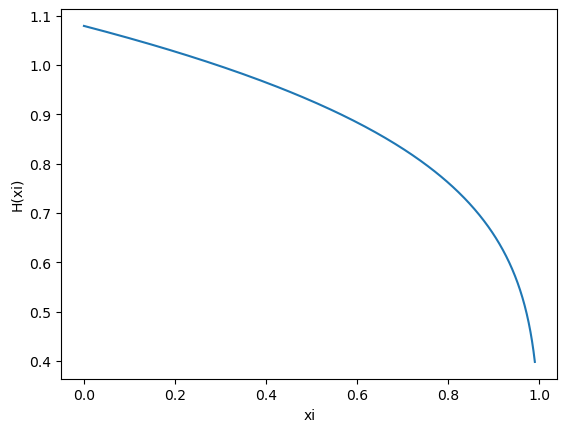

In [929]:
guess = 1e-2
A = 1
xi0 = 1 - guess
xi_left = 0
H0   = A * guess**0.2
Hp0  = - (A / 5) * guess**(-0.8)
alpha = 0
k = (5.0*alpha - 3)/11

def rhs(xi, y):
    H, Hp = y
    y0 = max(H, 1e-16)   # avoid division-by-zero
    dHp = (alpha - k) / (y0**4) + (3.0 * k * xi * Hp) / (y0**5) - 7.0 * (Hp**2) / y0
    return [Hp, dHp]

sol = solve_ivp(rhs, (xi0, xi_left), [H0, Hp0], method='Radau',rtol=1e-8, atol=1e-10, max_step=0.01)

xi = sol.t[::-1]
H = sol.y[0, ::-1]
plt.plot(xi, H)
plt.xlabel('xi'); plt.ylabel('H(xi)'); plt.show()


(3, 100)

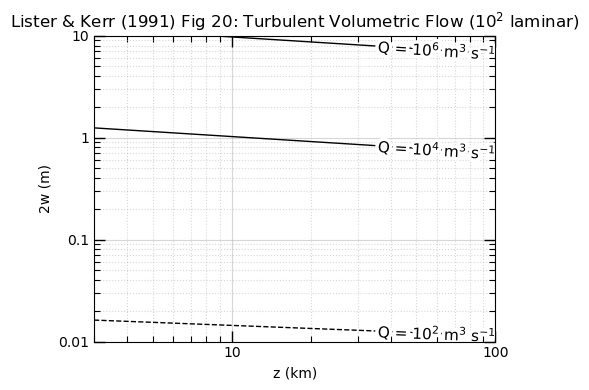

In [284]:
from labellines import labelLines
# Fig 20 from Lister & Kerr (1991) 
max_depth = 100e3
# z = np.logspace(np.log10(3000), np.log10(max_depth), 100)  # meters, log-spaced
# w = np.linspace(0.005, 5, 100) 
# W, Z = np.meshgrid(w, z)

z = np.linspace(3e3, 100e3, 100)  # meters, log-spaced
q = np.logspace(2, 6, 3)
Q, Z = np.meshgrid(q, z)
Qlog = np.log10(Q)

fig, ax = plt.subplots(layout='tight', figsize=(5,4))
for a in [2, 4, 6]:
    if a >= 4:
        Q = 10**a
        # x = 0 # at the center of the breadth
        # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
        # w_big = (1 - xi**2)**(3/2)
        w_big = 1 # at x=0
        # Eq 58
        w = 0.648 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
        e = np.log10(Q)
        ls = 'solid'
        ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
                label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    else:
        # w = (4 * Kc**2 * eta * Q / (np.pi * m**2 * delta_rho * g))**(1/5)
        Q = 10**a
        # x = 0 # at the center of the breadth
        # xi = 0.381 * x * ((g * delta_rho)**4 / (Q * eta * m**3 * z**3))**(1/10) # ~0
        # w_big = (1 - xi**2)**(3/2)
        w_big = 1 # at x=0
        # Eq 36
        w = 0.904 * ( (Q**3 * eta_w**3) / (m * (delta_rho * g)**2 * z) )**(1/10) * w_big
        e = np.log10(Q) 
        ls = 'dashed'
        ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
            label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')

labelLines(ax.get_lines(), xvals=[60, 60, 60], align=True, fontsize=11)
ax.set_ylabel('2w (m)')
ax.set_xlabel('z (km)')
ax.loglog()
ax.set_xlabel('z (km)')
ax.set_ylabel('2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.5, linestyle=':')
ax.set_title('Lister & Kerr (1991) Fig 20: Turbulent Volumetric Flow (10$^2$ laminar)')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 100)

In [422]:
# gamma function
from scipy.special import gamma
a_Lister = 12/7
G_up = gamma(3*a_Lister+2)
G_low = gamma(1/2*(3*a_Lister + 2))**2
print(f'G_up = {G_up:.4f}, \nG_low = {G_low:.4f}')
bN = 1/2 * (6*(3*a_Lister+1)/a_Lister)**(a_Lister/(3*a_Lister + 1)) * (G_up / G_low)**(1/(3*a_Lister + 1))
print(f'bN = {bN:.4f}')
A = 15.4 * eta_w**(-1/7) * (rhow * delta_rho * g)**(-3/7)
print(f'A = {A:.4e}')

G_up = 942.3223, 
G_low = 12.9515
bN = 2.3654
A = 2.5213e-01


(3, 100)

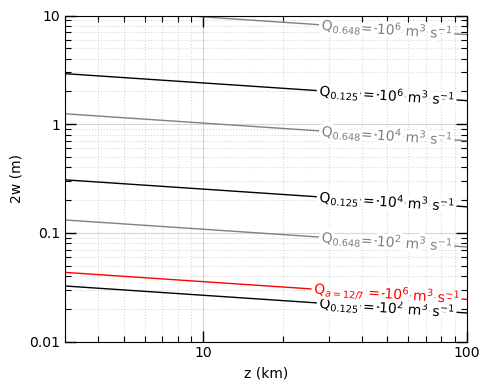

In [421]:
# the difference is that 10^2 is not laminar, see the next cell...
z = np.linspace(3e3, 100e3, 100)  # meters, log-spaced

fig, ax = plt.subplots(layout='tight', figsize=(5,4))
for a in [2, 4, 6]:
    Q = 10**a
    # x = 0 # at the center of the breadth
    # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
    # w_big = (1 - xi**2)**(3/2)
    w_big = 1 # at x=0
    # Eq 58
    w_648 = 0.648 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    w = 0.16 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    wLister = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
    e = np.log10(Q)
    ls = 'solid'
    ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
            label=rf'Q$_{{{0.125}}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    ax.plot(z/1e3, 2*wLister, color='red', linewidth=1, linestyle=ls,
            label=rf'Q$_{{a=12/7}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    ax.plot(z/1e3, 2*w_648, color='gray', linewidth=1, linestyle='solid', label=rf'Q$_{{{0.648}}}$= 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$' )

   
labelLines(ax.get_lines(), xvals=[50, 50, 50, 50, 50, 50, 50, 50, 50], align=True, fontsize=10)
ax.set_ylabel('2w (m)')
ax.set_xlabel('z (km)')
ax.loglog()
ax.set_xlabel('z (km)')
ax.set_ylabel('2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.5, linestyle=':')
# ax.set_title('Lister & Kerr (1991) Fig 20: Turbulent Volumetric Flow')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 100)

(3.0, 30.0)

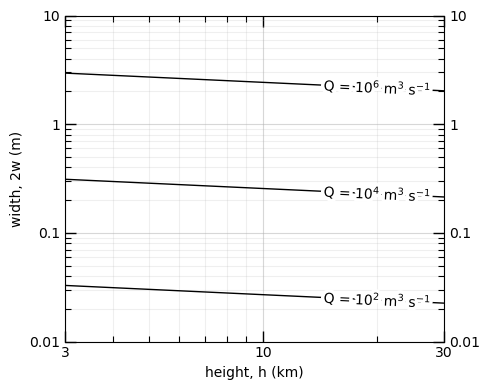

In [464]:
# the difference is that 10^2 is not laminar, see the next cell...
z = np.linspace(3e3, 100e3, 100)  # meters, log-spaced
a_Lister = 12/7
G_up = gamma(3*a_Lister+2)
G_low = gamma(1/2*(3*a_Lister + 2))**2
bN = 1/2 * (6*(3*a_Lister+1)/a_Lister)**(a_Lister/(3*a_Lister + 1)) * (G_up / G_low)**(1/(3*a_Lister + 1))
A = 15.4 * eta_w**(-1/7) * (rhow * delta_rho * g)**(-3/7)

fig, ax = plt.subplots(layout='tight', figsize=(5,4))
for a in [2, 4, 6]:
    Q = 10**a
    # x = 0 # at the center of the breadth
    # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
    # w_big = (1 - xi**2)**(3/2)
    w_big = 1 # at x=0
    # Eq 58
    w_648 = 0.648 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    w = 0.125 * ( (Q**21 * eta_w**3 * rhow**9) / (m**7 * (g * delta_rho)**5 * z**7) )**(1/43) * w_big
    wLister = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
    e = np.log10(Q)
    ls = 'solid'
    # ax.plot(z/1e3, 2*w, color='black', linewidth=1, linestyle=ls,
    #         label=rf'Q$_{{{0.125}}}$ = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    ax.plot(z/1e3, 2*wLister, color='black', linewidth=1, linestyle=ls,
            label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    # ax.plot(z/1e3, 2*w_648, color='gray', linewidth=1, linestyle='solid', label=rf'Q$_{{{0.648}}}$= 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$' )

   
labelLines(ax.get_lines(), xvals=[20, 20, 20], align=True, fontsize=10)

ax.loglog()
ax.set_xlabel('height, h (km)')
ax.set_ylabel('width, 2w (m)')
ax.set_axisbelow(True) # this puts gridlines behind contours
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_major_locator(FixedLocator([3, 10, 30, 100]))
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
ax.xaxis.set_minor_formatter(NullFormatter())
# ax.yaxis.set_minor_formatter(NullFormatter())
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1, direction='in', top=True, right=True, labelright=True)
ax.tick_params(which='minor', length=4, width=0.8, direction='in', top=True, right=True)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.2)
# ax.set_title('Lister & Kerr (1991) Fig 20: Turbulent Volumetric Flow')
ax.set_ylim(0.01, 10)
ax.set_xlim(3, 30)

In [458]:
1/(3*(12/7) + 1)

0.16279069767441862

In [446]:
# for 1e5
Q_test = 1e5
dub = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q_test**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
2*dub

array([0.95841778, 0.91532214, 0.8831075 , 0.85756637, 0.83651274,
       0.81867111, 0.80323497, 0.78966336, 0.77757657, 0.76669828,
       0.75682146, 0.74778714, 0.73947074, 0.73177291, 0.72461319,
       0.71792558, 0.71165527, 0.70575628, 0.70018969, 0.69492227,
       0.68992542, 0.68517439, 0.68064759, 0.67632611, 0.67219327,
       0.66823432, 0.66443611, 0.66078691, 0.65727621, 0.65389453,
       0.65063334, 0.64748487, 0.64444209, 0.6414986 , 0.63864851,
       0.63588648, 0.63320756, 0.63060723, 0.6280813 , 0.6256259 ,
       0.62323747, 0.62091267, 0.61864844, 0.61644188, 0.61429035,
       0.61219132, 0.61014248, 0.60814163, 0.60618672, 0.60427583,
       0.60240715, 0.60057898, 0.59878971, 0.59703784, 0.59532193,
       0.59364063, 0.59199268, 0.59037685, 0.58879201, 0.58723706,
       0.58571098, 0.58421278, 0.58274154, 0.58129635, 0.57987638,
       0.57848082, 0.5771089 , 0.57575989, 0.57443309, 0.57312782,
       0.57184344, 0.57057934, 0.56933494, 0.56810966, 0.56690

In [361]:
# emplacement times
emplacement_times = []
for a in [2, 4, 6]:
    Q = 10**a
    times = np.max(velocities) / Q  # seconds
    emplacement_times.append(times)
emplacement_times = np.array(emplacement_times)
emplacement_times_hours = emplacement_times / (60*60)
emplacement_times_hours

array([1.94008415e-04, 1.94008415e-06, 1.94008415e-08])

/Users/rcottom/anaconda3/lib/python3.10/site-packages/labellines/core.py:267: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.009278934146759399, xmax=0.016421339727032302, xval=0.37946350548045954). Clipping it into the allowed range.
  warnings.warn(
/Users/rcottom/anaconda3/lib/python3.10/site-packages/labellines/core.py:267: UserWarning: The value at position 1 in `xvals` is outside the range of its associated line (xmin=0.08795130312983956, xmax=0.15565130706684716, xval=0.7423176892629972). Clipping it into the allowed range.
  warnings.warn(


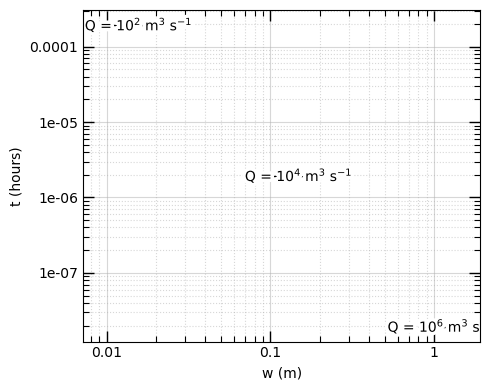

In [ ]:
# how long would the dikes need to stay open
# w by t for different Qs

times = []
z = np.linspace(3e3, max_depth, 100)  # meters, log-spaced
fig, ax = plt.subplots(layout='tight', figsize=(5,4))
for a in [2, 4, 6]:
    Q = 10**a
    # x = 0 # at the center of the breadth
    # xi = 0.66 * x * ((g * delta_rho)**16 / (Q**7 * eta * rhom**3 * (m * Z)**12))**(1/43) # ~0
    # w_big = (1 - xi**2)**(3/2)
    w_big = 1 # at x=0
    # Eq 58
    w = a_Lister * bN**3 / (6 * (3*a_Lister+1)) * (Q**3 / (A**3 * (g*delta_rho)**2 * m * z))**(1/(3*a_Lister + 1))
    t = np.max(velocities) / Q  # time to fill dike of breadth ~ height
    e = np.log10(Q)
    ls = 'solid'
    ax.plot(w, np.full_like(w, t/3600), color='black', linewidth=1, linestyle=ls,
            label=rf'Q = 10$^{{{e:.0f}}}$ m$^3$ s$^{{-1}}$')
    times.append(t)



In [386]:
z_max = 20e3
w_turb = 1
q1 = m**7 * (g*delta_rho)**3 * z_max**5 / (eta_w**5 * rhow**9)
q2 = ( w_turb / 0.16 * (1) )**43 # ξ = 1
Q_grid_turb = (q1 * q2)**(1/21)
Q_m3_turb = Q_grid_turb
Q_km3_turb = Q_m3_turb/1e9 # km3/s

# how much liquid can those injection rates supply?
# Q_km3_6h = Q_km3 * (60 * 60 * 6) # km3/6h
Re_Q = rhow * 10**2 / (2 * eta_w * w_turb)
print(f"Re = {Re_Q:.2e}")
Q_m3_1h_turb = Q_m3_turb * (60 * 60 * 1) # km3/2h
Q_km3_1h_turb = Q_km3_turb * (60 * 60 * 1) # km3/2h
print(f"For w = {w_turb} m.")

print(f'Volume injected (turbulent) = {np.nanmax(Q_m3_1h_turb):.2e} m3 or {np.nanmax(Q_km3_1h_turb):.3f} km3 over 1 hour.')
Q_m3_2h_turb = Q_m3_turb * (60 * 60 * 2) # km3/2h
Q_km3_2h_turb = Q_km3_turb * (60 * 60 * 2) # km3/2h
print(f"Volume injected (turbulent) = {np.nanmax(Q_m3_2h_turb):.2e} m3 or {np.nanmax(Q_km3_2h_turb):.3f} km3 over 2 hours.")
Q_m3_6h_turb = Q_m3_turb * (60 * 60 * 6) # km3/6h
Q_km3_6h_turb = Q_km3_turb * (60 * 60 * 6) # km3/6h
print(f"Volume injected (turbulent) = {np.nanmax(Q_m3_6h_turb):.2e} m3 or {np.nanmax(Q_km3_6h_turb):.3f} km3 over 6 hours.")
A = 25 # km2
r = ((A*1e6)/np.pi)**0.5
print(f"A region of {A} km2 would be {(2*r)/1e3:.2f} km in diameter.")
h = 1e3 # m
V_elpd = 4/3 * np.pi * (r)**2 * h
print(f"Volume of the ellipsoidal sill = {V_elpd:.2e} m3 or {V_elpd/1e9:.1f} km3.")

time = V_elpd / Q_m3_1h_turb
print(f"Time to fill the sill (turbulent) = {time:.2f} hrs.")
check = Q_m3_1h_turb * time
print(f"V_1h*time = {check:.2e} m3 or {check/1e9:.1f} km3.")

# V_sill = 8/15 * 25*1e6 * 1e3
# V_sill_km3 = V_sill / 1e9
# print(f"Michaut and Manga (2014) sill volume = {V_sill_km3:.1f} km3. \nIt seems like the injection rates would fill the sill and then some. \nHowever, a turbulent flux may not fill the sill.")

Re = 5.12e+07
For w = 1 m.
Volume injected (turbulent) = 1.47e+09 m3 or 1.467 km3 over 1 hour.
Volume injected (turbulent) = 2.93e+09 m3 or 2.935 km3 over 2 hours.
Volume injected (turbulent) = 8.80e+09 m3 or 8.804 km3 over 6 hours.
A region of 25 km2 would be 5.64 km in diameter.
Volume of the ellipsoidal sill = 3.33e+10 m3 or 33.3 km3.
Time to fill the sill (turbulent) = 22.72 hrs.
V_1h*time = 3.33e+10 m3 or 33.3 km3.


In [405]:
velocities[:,0]

array([ 4.41726104,  8.2818067 , 10.84732453, 12.91280669, 14.69070126,
       16.27552859, 17.71916922, 19.05374202, 20.30076876, 21.47550556,
       22.58923342, 23.65057279, 24.66628713, 25.64179884, 26.58153447,
       27.48916336, 28.36776743, 29.21996503, 30.04800298, 30.85382651,
       31.63913301, 32.40541413, 33.15398908, 33.88603133, 34.60259016,
       35.30460839, 35.99293681, 36.6683464 , 37.33153834, 37.9831526 ,
       38.62377518, 39.25394421, 39.87415533, 40.48486619, 41.08650043,
       41.67945111, 42.26408371, 42.84073877, 43.40973423, 43.97136742,
       44.52591695, 45.07364426, 45.61479513, 46.14960088, 46.67827962,
       47.20103723, 47.71806831, 48.22955702, 48.73567787, 49.23659639,
       49.73246979, 50.2234475 , 50.70967172, 51.1912779 , 51.66839517,
       52.14114677, 52.60965039, 53.07401851, 53.53435876, 53.99077417,
       54.44336344, 54.89222121, 55.33743829, 55.77910186, 56.21729566,
       56.65210021, 57.08359296, 57.51184845, 57.93693847, 58.35

In [465]:
# u from Q and w
B = []
for v in velocities[:,0]:
    # Q is m3/s and v is m/s, so A = Q/v in m2
    A = 1e5 / v
    b = A / 1 # w = 1 m
    B.append(b)
B

[22638.462845343543,
 12074.659986645729,
 9218.863117864896,
 7744.2497541930525,
 6807.026989689123,
 6144.193687655735,
 5643.605450939647,
 5248.312897838279,
 4925.92183071889,
 4656.467793047893,
 4426.887719191825,
 4228.22740362249,
 4054.116433738557,
 3899.8823999978445,
 3762.010056508617,
 3637.797145954866,
 3525.1276025491934,
 3422.317579905251,
 3328.0081891239734,
 3241.0890739214756,
 3160.6428649170557,
 3085.90409022284,
 3016.228296415023,
 2951.0685107777167,
 2889.957067475545,
 2832.491410425251,
 2778.322883783324,
 2727.1477943720406,
 2678.7002211596764,
 2632.7461820343397,
 2589.0788651174494,
 2547.5147023842983,
 2507.8901152260128,
 2470.0588001483843,
 2433.8894517618396,
 2399.2638421697375,
 2366.0751926511225,
 2334.226786480193,
 2303.6307817853167,
 2274.207191225956,
 2245.883001473537,
 2218.591410407276,
 2192.2711638675037,
 2166.865976965845,
 2142.3240275005014,
 2118.597511093775,
 2095.6422493567493,
 2073.4173437694167,
 2051.8848691037124

In [389]:
u_reqd = eta_w * 3000 / rhow * w_turb
u_reqd

0.002926829268292683

Text(0, 0.5, 'h (km)')

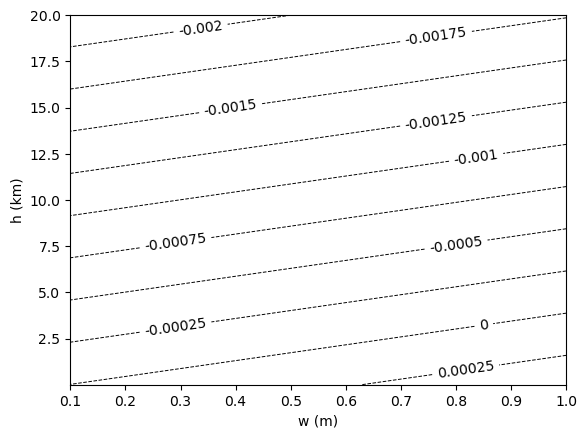

In [591]:
t = np.linspace(0, 60*60*6, 100) # 6 hrs
w = np.linspace(0.1, 1, 100)
z = np.linspace(1, max_depth, 100)
# pressure based on laminar velocity
W, Z = np.meshgrid(w, z)
DelP = - (3 * eta_w * velocities) / W**2 # L&K 8a
DP_viscous = eta_w * Z**2 / (W**2) * t # pressure drop 
sigma_x = nu / (1 - nu) * rhoi * g * Z
WL = ((DP + DelP) - sigma_x) / m

lines = plt.contour( W, Z/1e3, WL, levels=10, colors='black', linewidths=0.7, linestyles='dashed')
# cbar = plt.colorbar(label='Aspect Ratio, w/h')
plt.clabel(lines, inline=True, fontsize=10, fmt=r'%g')
plt.xlabel('w (m)')
plt.ylabel('h (km)')


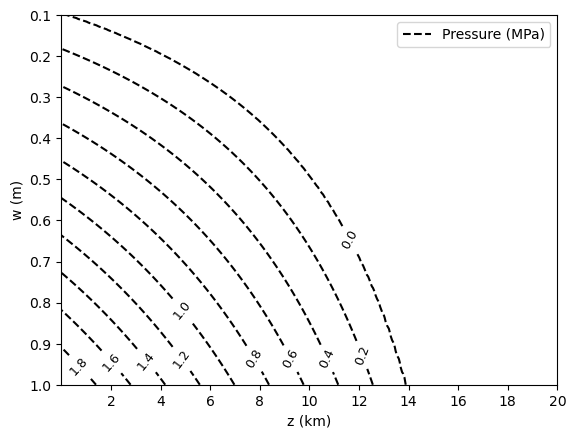

In [523]:
# aspect ratios with pressures calculated using Bernoulli eq
DPh = delta_rho * g * Z
Pstatic = DP - DPh 
Pdyn = 0.5 * rhow * velocities**2
P_tot = Pstatic + Pdyn
WZ = W / Z
plt.figure()
BigP = P_tot >= 0
cs = plt.contour(Z/1e3, W, P_tot/1e6 * BigP, colors='black', 
                 levels=[0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8], linestyles='dashed')
proxy = plt.Line2D([], [], color='black', linestyle='dashed', label='Pressure (MPa)')
plt.legend(handles=[proxy], loc='best')
plt.clabel(cs, inline=True, fmt='%.1f', fontsize=9)
plt.ylabel('w (m)')
plt.xlabel('z (km)')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))


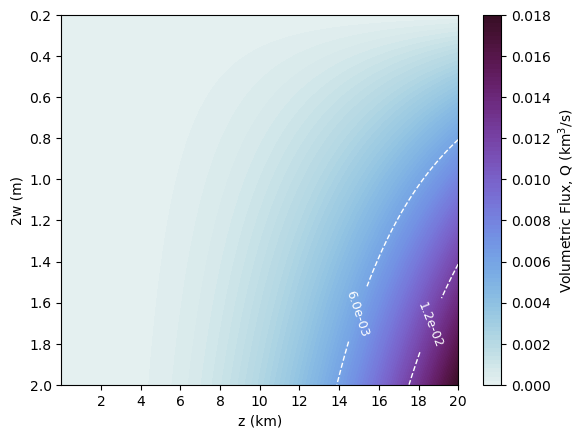

In [ ]:
# Menand and Tait (2002) Q calculation (Galetto 2021 Eq 2)
u = np.linspace(1e-3, 40, 100) # (m/s) velocities
U_MT, DP_MT = np.meshgrid(u, DP)

Q_MTnumerator = 2 * (1 - nu**2) * np.pi * U_MT * DP_MT**3
Q_MTdenominator = E * (delta_rho * g)**2
Q_MT = Q_MTnumerator / Q_MTdenominator

colors = plt.contourf(Z/1e3, 2*W, Q_MT/1e9, levels=100, cmap='cmo.dense', )
cbar = plt.colorbar(label='Volumetric Flux, Q (km$^3$/s)')
cont = plt.contour(Z/1e3, 2*W, Q_MT/1e9, levels=2, colors='white', linewidths=1, linestyles='dashed')
plt.clabel(cont, inline=True, fontsize=9, fmt='%.1e', colors='white')
plt.ylabel('2w (m)')
plt.xlabel('z (km)')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

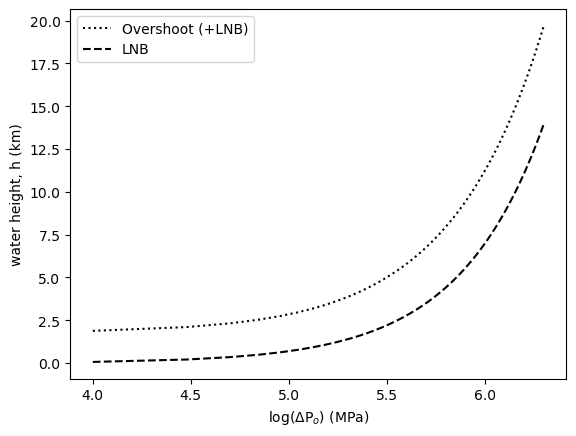

In [548]:
# level of neutral buoyancy and overshoot height
w = np.linspace(0.1, 1, 100)
Ho = np.sqrt(w * m / (delta_rho * g))
LNB = DP / (delta_rho * g)
plt.figure()
plt.plot(np.log10(DP), (LNB + Ho)/1e3, color = 'black', linestyle = 'dotted', label='Overshoot (+LNB)')
plt.plot(np.log10(DP), LNB/1e3, color = 'black', linestyle = 'dashed', label='LNB')
plt.xlabel('log(ΔP$_o$) (MPa)')
plt.ylabel('water height, h (km)')
plt.legend(loc='best')
# This implies that for 

Text(0, 0.5, 'w (m)')

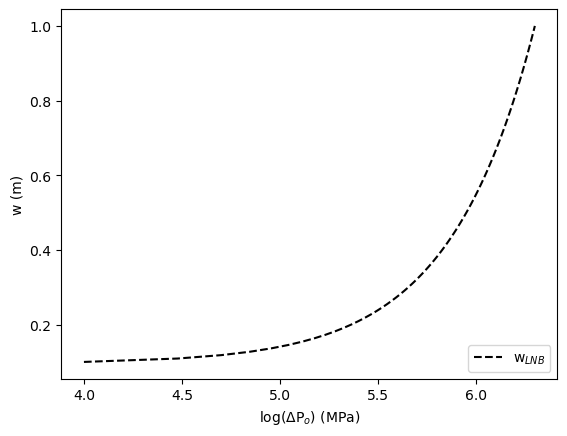

In [549]:
# w required for LNB
w_LNB = (delta_rho * g) * Ho**2 / (m)
plt.plot(np.log10(DP), w_LNB, color = 'black', linestyle = 'dashed', label='w$_{LNB}$')
plt.xlabel('log(ΔP$_o$) (MPa)')
plt.legend(loc='lower right')
plt.ylabel('w (m)')

In [ ]:
# Fig 16 from Lister & Kerr (1991)


array([[ 2.01142739e-06,  6.27532411e-06,  1.05392105e-05, ...,
         4.15605219e-04,  4.19869070e-04,  4.24132921e-04],
       [-2.01096199e-05, -1.58456893e-05, -1.15817765e-05, ...,
         3.93484378e-04,  3.97748229e-04,  4.02012080e-04],
       [-4.22306026e-05, -3.79666487e-05, -3.37027179e-05, ...,
         3.71363537e-04,  3.75627388e-04,  3.79891239e-04],
       ...,
       [-2.14371377e-03, -2.13944927e-03, -2.13518492e-03, ...,
        -1.73011633e-03, -1.72585248e-03, -1.72158862e-03],
       [-2.16583463e-03, -2.16157013e-03, -2.15730578e-03, ...,
        -1.75223717e-03, -1.74797332e-03, -1.74370946e-03],
       [-2.18795549e-03, -2.18369099e-03, -2.17942663e-03, ...,
        -1.77435801e-03, -1.77009416e-03, -1.76583030e-03]])

In [290]:
index = 0
for i in range(len(DP)):
    if np.any(DP - DP_viscous < 0):
        index += 1
        print(f"Index {index}: viscous pressure drop exceeds overpressure")

Index 1: viscous pressure drop exceeds overpressure
Index 2: viscous pressure drop exceeds overpressure
Index 3: viscous pressure drop exceeds overpressure
Index 4: viscous pressure drop exceeds overpressure
Index 5: viscous pressure drop exceeds overpressure
Index 6: viscous pressure drop exceeds overpressure
Index 7: viscous pressure drop exceeds overpressure
Index 8: viscous pressure drop exceeds overpressure
Index 9: viscous pressure drop exceeds overpressure
Index 10: viscous pressure drop exceeds overpressure
Index 11: viscous pressure drop exceeds overpressure
Index 12: viscous pressure drop exceeds overpressure
Index 13: viscous pressure drop exceeds overpressure
Index 14: viscous pressure drop exceeds overpressure
Index 15: viscous pressure drop exceeds overpressure
Index 16: viscous pressure drop exceeds overpressure
Index 17: viscous pressure drop exceeds overpressure
Index 18: viscous pressure drop exceeds overpressure
Index 19: viscous pressure drop exceeds overpressure
In

In [166]:
# max_depth = 20e3 # m
# z = np.linspace(1, max_depth, 100) 
# w = np.linspace(0.1, 1, 100) 
# W, Z = np.meshgrid(w, z)
# q1 = (W / (0.904))**10
# q2 = (Z * m * (delta_rho * g)**2) / (eta_w**3)
# Q = (q1 * q2)**(1/3)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# pcm1 = ax1.contourf(Z/1e3, W, Q, levels=50, cmap='cmo.dense_r', norm=LogNorm())
# cbar1 = fig.colorbar(pcm1, ax=ax1, label='Volumetric Flux, Q (m$^3$/s)')
# ax1.set_xlabel('z (km)')
# ax1.set_ylabel('2w (m)')
# ax1.invert_xaxis()

# pcm2 = ax2.contourf(Z/1e3, W, Q/1e6, levels=100, cmap='cmo.dense_r')
# cont2 = ax2.contour(Z/1e3, W, Q/1e6, levels=3, colors='black', linewidths=0.5)
# cbar2 = fig.colorbar(colors, label='Volumetric Flux, Q (Mm$^3$/s)')
# ax2.clabel(cont2, inline=True, fontsize=10, fmt=lambda x: f'Q = {x/1e3} Gm$^3$/s')
# ax2.set_ylabel('2w (m)')
# ax2.set_xlabel('z (km)')
# ax2.invert_xaxis()


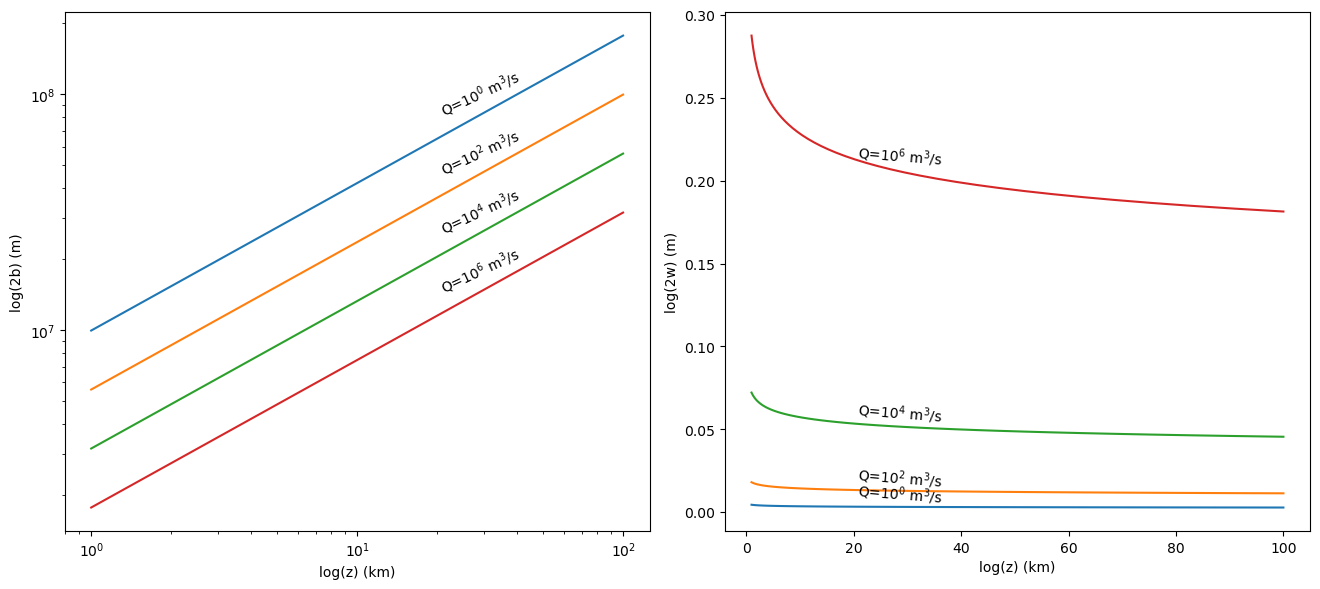

In [68]:
G_term = delta_rho * g
Q_values = [1.0, 1e2, 1e4, 1e6]
Z_km = np.logspace(0, 2, 50) 
Z_m = Z_km * 1000.0

def width_2w(Q, Z):
    return (2 * 0.904) * (Q**3 * eta_w**3 / (m * G_term**2 * Z))**(0.1)
def breadth_2b(Q, Z):
    # 2b = (2 / 0.381) * (m^4 * Z^5 / (G_term^3 * Q * eta))^(1/8)
    term_B = (m**4) / (G_term**3 * eta_w)
    return (2 / 0.381) * (term_B)**(0.125) * Q**(-0.125) * Z**(5/8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.set_xlabel('log(z) (km)')
ax1.set_ylabel('log(2b) (m)')
ax1.set_xscale('log')
ax1.set_yscale('log')

for Q in Q_values:
    b_m = breadth_2b(Q, Z_m)
    w_m = width_2w(Q, Z_m)
    ax1.plot(Z_km, b_m)
    ax2.plot(Z_km, w_m)
    exponent = int(np.log10(Q))
    label = fr'Q=$10^{{{exponent}}}$ m$^3$/s'
    xy1 = (Z_km[-20], b_m[-15])
    xy2 = (Z_km[-20], w_m[-15])
    ax1.annotate(label, xy=xy1, xytext=(15, 0), textcoords='offset points', va='bottom', rotation = 25)
    ax2.annotate(label, xy=xy2, xytext=(15, 0), textcoords='offset points', va='bottom', rotation = -4.5)

ax2.set_xlabel('log(z) (km)')
ax2.set_ylabel('log(2w) (m)')
# ax2.set_xscale('log')
# ax2.set_yscale('log')

# for ax in [ax1, ax2]:
#     ax.xaxis.set_major_formatter(ticker.LogFormatterExponent())
#     ax.yaxis.set_major_formatter(ticker.LogFormatterExponent())
#     ax.grid(True, which="both", ls="--", alpha=0.5)


plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make room for labels
plt.show()

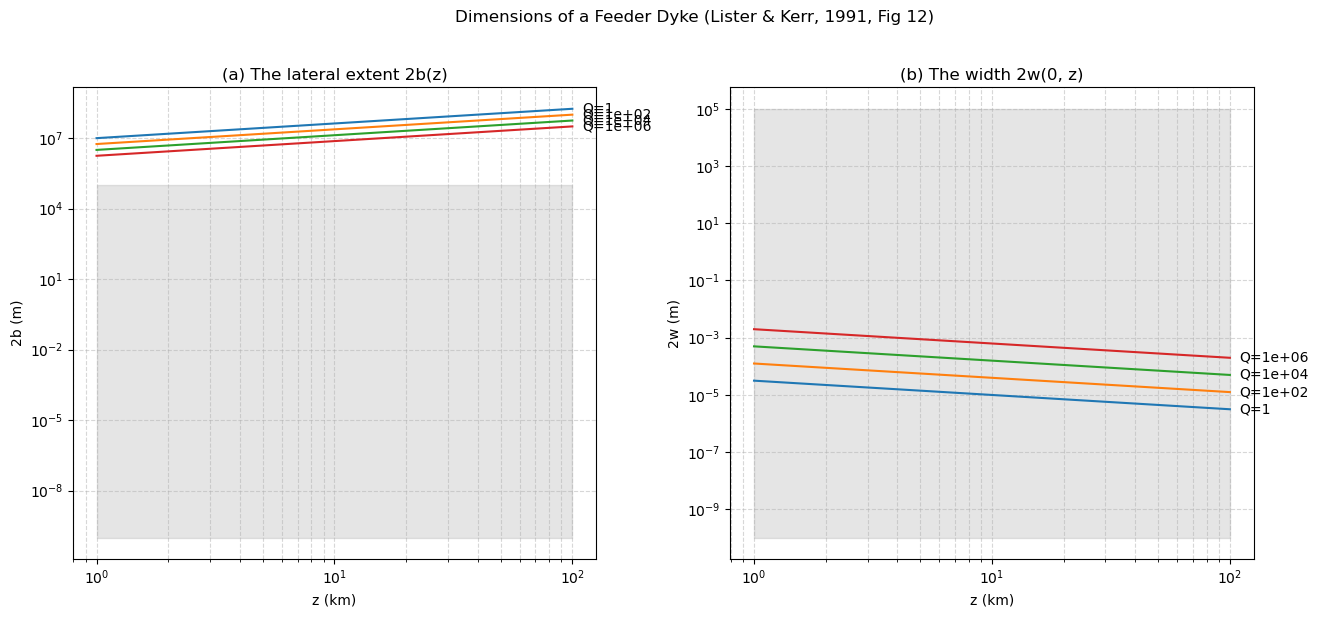

In [69]:
# 1. Define Physical Constants & Calculation Parameters
G_term = delta_rho * g
Q_values = [1.0, 1e2, 1e4, 1e6]  # Flux rates (m^3/s)
Z_km = np.logspace(0, 2, 50)      # Height in km (1 to 100 km)
Z_m = Z_km * 1000.0              # Height in meters

# 2. Define functions based on similarity solutions (Eqs 36 and 37b)
def width_2w(Q, Z):
    """Calculates width at the centerline (2w)."""
    term_A = (Q**3 * eta_w**3) / (m**2 * G_term**2)
    return (2 * 0.904) * (term_A)**0.1 * Z**-0.5

def breadth_2b(Q, Z):
    """Calculates lateral extent (2b)."""
    term_B = (m**4) / (G_term**3 * eta_w)
    return (2 / 0.381) * (term_B)**0.125 * Q**-0.125 * Z**(5/8)

# 3. Plotting (Replicating Figure 12 structure)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
fig.suptitle(r'Dimensions of a Feeder Dyke (Lister & Kerr, 1991, Fig 12)', y=1.02)

# --- Plotting Loop ---
for Q in Q_values:
    # Calculate breadth and width
    BREADTH_m = breadth_2b(Q, Z_m)
    WIDTH_m = width_2w(Q, Z_m)
    
    # Plot data
    ax1.plot(Z_km, BREADTH_m)
    ax2.plot(Z_km, WIDTH_m)

    # Add inline labels
    label = f'Q={Q:.0e}' if Q >= 1e2 else f'Q={Q:.0f}'
    ax1.text(Z_km[-1] * 1.1, BREADTH_m[-1], label, va='center')
    ax2.text(Z_km[-1] * 1.1, WIDTH_m[-1], label, va='center')

# --- Subplot (a): Lateral Extent 2b(z) ---
ax1.set_title('(a) The lateral extent 2b(z)')
ax1.set_ylabel('2b (m)')
ax1.set_yscale('log')

# --- Subplot (b): Width 2w(0, z) ---
ax2.set_title('(b) The width 2w(0, z)')
ax2.set_ylabel('2w (m)')
ax2.set_yscale('log')

# --- Common Axes Formatting ---
for ax in [ax1, ax2]:
    ax.set_xlabel('z (km)')
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="--", alpha=0.5)
    # Add shaded region where solution is approximate (z < b)
    ax.fill_between(Z_km, 1e-10, 1e5, where=Z_km < BREADTH_m/1000, color='gray', alpha=0.2)

plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust layout to make room for labels
plt.show()

In [70]:
# propagation height for an ice dike (Eqns 14 L&K 1991)
p_height = (Kc / (delta_rho * g))**(2/3)
p_width = ( (Kc**4 * (1-nu)**3) / (delta_rho * g * G**3) )**(1/3)
print(f"propagation height = {p_height/1e3:.2f} km \npropagation width = {p_width*1e3:.2f} mm")
print(f"aspect ratio w/h = {p_width / p_height:.2e}")

# DPh and DP_uz may be arrays; summarise instead of trying to format the whole array
print(f"Ph: mean={np.nanmean(DPh)/1e6:.2f} MPa, min={np.nanmin(DPh)/1e6:.2f} MPa, max={np.nanmax(DPh)/1e6:.2f} MPa")
print(f"ΔP_o: mean={np.nanmean(DP_uz)/1e6:.2f} MPa, min={np.nanmin(DP_uz)/1e6:.2f} MPa, max={np.nanmax(DP_uz)/1e6:.2f} MPa")

propagation height = 0.37 km 
propagation width = 4.05 mm
aspect ratio w/h = 1.11e-05
Ph: mean=1.56 MPa, min=0.00 MPa, max=2.34 MPa
ΔP_o: mean=0.51 MPa, min=0.01 MPa, max=1.00 MPa


In [71]:
# Elastic and hydrostatic pressure, and h/w

Pe = m / (delta_rho * g)


In [72]:
# Pex computation

Pexs = [] # Pa

for i in range(len(ri)):
    r = np.linspace(rc, R, 100) # (m)
    depth_new = R - ri[i]

    if i == 0:
        depth_old = R - rii
        dz = 0
        ur = np.zeros(len(r))
        sigmar = np.zeros(len(r))
        sigmat = np.zeros(len(r))
        Press = np.zeros(len(r))

    elif i > 0:
        dz = depth_new - depth_old # (m) amount of freezing
        sigmar = prevpress/((R/depth_new)**3 - 1) * (1 - (R/r)**3) 
        sigmat = prevpress/((R/depth_new)**3 - 1) * (1 + 0.5*(R/r)**3)
        ur = -r/E * (sigmar - 2 * nu * sigmat)
    
    Press = np.zeros(len(r))
    for j in range(len(r)):
        Press += Pex(beta, rc, ur, rhow, rhoi, dz, ri[i])
        # += because it accumulates over time

    Pexs.append(Press)
    prevpress = Press
    depth_old = depth_new

Pexs_a = np.array(Pexs)
# isinstance(Pexs, list)
if isinstance(Press, list):
    print("✓ Press is a list")
else: 
    print(f"X Press is not a list, but a {type(Press)}")
    print(f"of shape: {Press.shape}")

if isinstance(Pexs, list):
    print("✓ Pexs is a list")
else: 
    print("X Pexs is not a list")
    print(f"of shape: {Pexs.shape}")

if isinstance(Pexs_a, np.ndarray):
    print(f"✓ Pexs_a is a numpy array of shape {Pexs_a.shape}")
else: 
    print("X Pexs_a is not a numpy array")
    print(f"of shape: {Pexs_a.shape}")

X Press is not a list, but a <class 'numpy.ndarray'>
of shape: (100,)
✓ Pexs is a list
✓ Pexs_a is a numpy array of shape (50001, 100)


In [73]:
Pexs_a

array([[       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [   85092.48899389,    85092.48899389,    85092.48899389, ...,
           85092.48899389,    85092.48899389,    85092.48899389],
       [20355226.82837881, 20355226.82837882, 20355226.82837882, ...,
        20355226.8283803 , 20355226.82838031, 20355226.82838031],
       ...,
       [   54712.39851047,    54712.54069998,    54712.68262878, ...,
           54725.07488704,    54725.19479703,    54725.31450578],
       [   54711.95025803,    54712.0924509 ,    54712.23438305, ...,
           54724.62693412,    54724.74684695,    54724.86655853],
       [   54711.50215942,    54711.64435564,    54711.78629115, ...,
           54724.17913499,    54724.29905066,    54724.41876506]])

In [ ]:
# P vs w/h for Europan vs silicate dikes
